## ✅ Résumé clair du projet

### 🎯 Objectif

Construire un modèle de **CCF Forward Looking (FL)** pour enrichir le calcul de l’**EAD** dans le cadre IFRS 9, en tenant compte des variables **macroéconomiques** et du **cycle de crédit**.
👉 Le but est de projeter un **CCF prévisionnel à 3 ans** à partir d’observations historiques et de données macro.

---

## 🧭 Étapes de travail recommandées (en Python)

### 1. 🔧 **Préparation des données**

* Charger les séries annuelles de CCF **observées (PiT)** par segment (dans Excel ou CSV)
* Charger les **CCF TTC (Through The Cycle)** servant de point d’ancrage
* Récupérer les séries **macro INSEE** (voir page 13 du PDF) :

  * PIB
  * Inflation
  * Chômage
  * Prix du logement

### 2. 📊 **Analyse exploratoire**

* Étudier la **stationnarité** des séries : `adfuller()` de `statsmodels`
* Visualiser les corrélations entre CCF et les variables macro (`heatmap`, `corr()`)
* Lisser éventuellement les séries via moyennes mobiles

### 3. 📈 **Modélisation**

Deux approches possibles :

#### A. Régression économique

> `CCF_PIT ~ macro_var1 + macro_var2 + …`

* Régression linéaire (`LinearRegression`)
* Ridge / Lasso pour éviter le sur-apprentissage
* Option : utiliser `statsmodels.OLS()` pour avoir les p-values

#### B. Approche hybride TTC + FL

> `CCF_proj = CCF_TTC + impact_macro`

* Calculer l’écart entre CCF\_PIT et CCF\_TTC (Δ)
* Modéliser Δ avec les variables macroéconomiques
* Ajouter la prévision de Δ au CCF\_TTC pour obtenir le CCF prévisionnel

---

### 4. 📉 **Projection**

* Créer un modèle `predict(X_macro_future)` pour les 3 prochaines années
* Appliquer le modèle sur des **scénarios macro projetés**
* Plafonner les valeurs à 100% (page 11)

---

### 5. 📁 Livrables attendus

* Un `main.py` exécutable
* Un `notebook` exploratoire
* Un fichier `ccf_model.py` avec la logique de modélisation
* Une **synthèse claire** (PDF, 3-4 pages) :

  * Hypothèses
  * Données utilisées
  * Modèles testés
  * Résultats / projections



### 📁 **Données\_CFF\_SERIE\_GLOBALE\_VF.csv**

| Variable               | Description                                                                                              | Remarque                                                                                                           |
| ---------------------- | -------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| `date`                 | Date d’arrêté. Correspond à la génération 12 mois avant le défaut                                        | Les données sont trimestrielles. Tester aussi une modélisation annuelle, comme c’est le cas en production bancaire |
| `Indicateur_Moyen_1_5` | CCF brut moyen trimestriel pour la population des segments 1 à 5 (où le CCF est variable)                | Variable cible à projeter                                                                                          |
| `Effectif_Pourc_1_5`   | % d’effectifs pour une date donnée (segments 1 à 5)                                                      | Sert à pondérer les périodes, utile pour améliorer la corrélation avec les variables macro                         |
| `Indicateur_Moyen_1_6` | CCF brut moyen trimestriel pour l’ensemble de la population (incluant le segment 6 avec CCF fixé à 100%) | Variable cible à projeter                                                                                          |
| `Effectif_Pourc_1_6`   | % d’effectifs pour une date donnée (segments 1 à 6)                                                      | Sert à pondérer les périodes et tester l’apport du segment 6 malgré son CCF fixe                                   |

---

### 📁 **Données\_CFF\_PAR\_SEGMENT.csv**

| Variable                | Description                                                                       | Remarque                                                                                                                       |
| ----------------------- | --------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| `Date`                  | Date d’arrêté (de 200903 à 202212)                                                | Tester modélisation trimestrielle **et** annuelle                                                                              |
| `Note_ref`              | Segment du CCF                                                                    | —                                                                                                                              |
| `Indicateur_moyen_Brut` | CCF moyen brut par segment                                                        | Variable cible                                                                                                                 |
| `PourcNote`             | % de la population d’un segment par rapport à l’ensemble des trimestres existants | Peu utile au début, mais à tester pour analyse de stationnarité                                                                |
| `PourcNoteCohorte`      | % dans un segment par rapport à toute la cohorte (6 segments)                     | Séries souvent instables, peut fausser les analyses. À tester avec pondération par les effectifs (ex : Weighted Least Squares) |
| `PourcNoteCohorte5`     | % dans un segment par rapport à la cohorte 1 à 5 (exclut segment 6 à CCF fixe)    | À privilégier pour éviter la distorsion induite par le segment 6                                                               |



# CHARGER LES DONNES

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

In [10]:
# Chargement des données
segment_path = 'data/Données_CCF_PAR_SEGMENT.csv'
global_path = 'data/Données_CCF_SERIE_GLOBALE_VF.csv'

df_global = pd.read_csv(global_path, sep=";")
df_segment = pd.read_csv(segment_path, sep=";")

# Statistiques descriptives
desc_global = df_global.info()
desc_segment = df_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  60 non-null     object
 1   Indicateur_Moyen_1_5  60 non-null     object
 2   Effectif_Pourc_1_5    60 non-null     object
 3   Indicateur_Moyen_1_6  56 non-null     object
 4   Effectif_Pourc_1_6    56 non-null     object
dtypes: object(5)
memory usage: 2.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cod_prd_ref            360 non-null    object
 1   note_ref               360 non-null    int64 
 2   Indicateur_moyen_Brut  360 non-null    object
 3   PourcNote              360 non-null    object
 4   PourcNoteCohorte       360 non-null    object
 5   PourcNoteCohorte5      360 non-null    obj

In [11]:
macro_path = 'data/macrovariables/historique_macro_variables_projet_CCF_FowardLooking_IFRS9.xlsx'
df_macro = pd.read_excel(macro_path)

print(df_macro.head())

  date_dernier_mois  PIB  IPL  TCH  Inflation  PIB_diff1  IPL_diff1  \
0           1980-03  0.0  0.0  5.3        0.0        NaN        NaN   
1           1980-06  0.0  0.0  5.3        0.0        0.0        0.0   
2           1980-09  0.0  0.0  5.4        0.0        0.0        0.0   
3           1980-12  0.0  0.0  5.6        0.0        0.0        0.0   
4           1981-03  0.0  0.0  6.0        0.0        0.0        0.0   

   TCH_diff1  Inflation_diff1  
0        NaN              NaN  
1        0.0              0.0  
2        0.1              0.0  
3        0.2              0.0  
4        0.4              0.0  


# EXPLO DES DONNEES

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Nettoyage et conversion des colonnes numériques avec virgules
for col in ['Indicateur_Moyen_1_5', 'Effectif_Pourc_1_5', 'Indicateur_Moyen_1_6', 'Effectif_Pourc_1_6']:
    df_global[col] = df_global[col].str.replace(',', '.').astype(float)

for col in ['Indicateur_moyen_Brut', 'PourcNote', 'PourcNoteCohorte', 'PourcNoteCohorte5']:
    df_segment[col] = df_segment[col].str.replace(',', '.').astype(float)

# Conversion des dates
df_global['date'] = pd.to_datetime(df_global['date'])

# Nettoyage des espaces et conversion en date trimestrielle
df_segment['date'] = pd.to_datetime(df_segment['cod_prd_ref'].str.strip().str.replace('T', 'Q'))

# Affichage des dates uniques triées pour vérification
df_segment['date'].sort_values().unique()

# Statistiques descriptives
desc_global = df_global.describe()
desc_segment = df_segment.describe()

print(desc_global)
print("----")
print(desc_segment)

                      date  Indicateur_Moyen_1_5  Effectif_Pourc_1_5  \
count                   60             60.000000           60.000000   
mean   2016-01-05 21:36:00              0.710161            0.016667   
min    2009-01-01 00:00:00              0.475551            0.008257   
25%    2012-01-09 06:00:00              0.607004            0.012825   
50%    2016-01-05 12:00:00              0.690971            0.016108   
75%    2020-01-01 18:00:00              0.820344            0.021441   
max    2023-01-10 00:00:00              0.970606            0.024525   
std                    NaN              0.123135            0.004892   

       Indicateur_Moyen_1_6  Effectif_Pourc_1_6  
count             56.000000           56.000000  
mean               0.863108            0.017857  
min                0.749491            0.009202  
25%                0.825782            0.014296  
50%                0.856909            0.017892  
75%                0.910321            0.021149  
m

C:\Users\dumas\AppData\Local\Temp\ipykernel_42620\3820830927.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_segment['date'] = pd.to_datetime(df_segment['cod_prd_ref'].str.strip().str.replace('T', 'Q'))


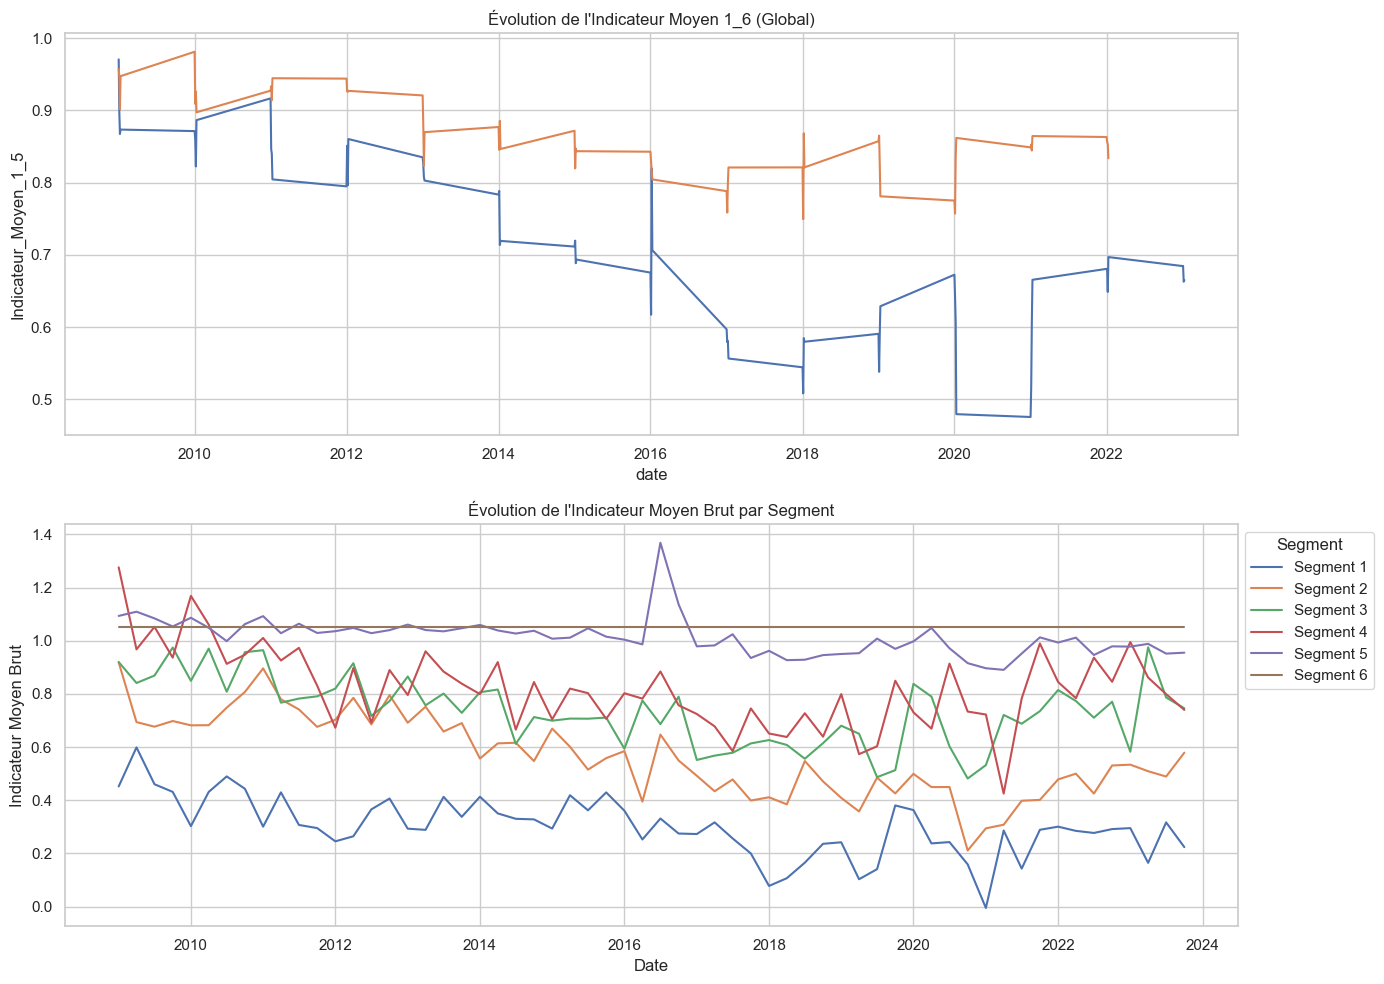

In [13]:
# Visualisations
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Global CCF 1_5
sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_5', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_5 (Global)")

sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_6', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_6 (Global)")


# Plusieurs segments superposés avec légende
for i in range(0, 6):
    segment = df_segment['note_ref'].unique()[i]
    df_plot_seg = df_segment[df_segment['note_ref'] == segment]
    sns.lineplot(
        data=df_plot_seg,
        x='date',
        y='Indicateur_moyen_Brut',
        ax=axs[1],
        label=f"Segment {segment}"
    )

axs[1].set_title("Évolution de l'Indicateur Moyen Brut par Segment")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Indicateur Moyen Brut")
axs[1].legend(title="Segment", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()



#### DONNEES INSEE

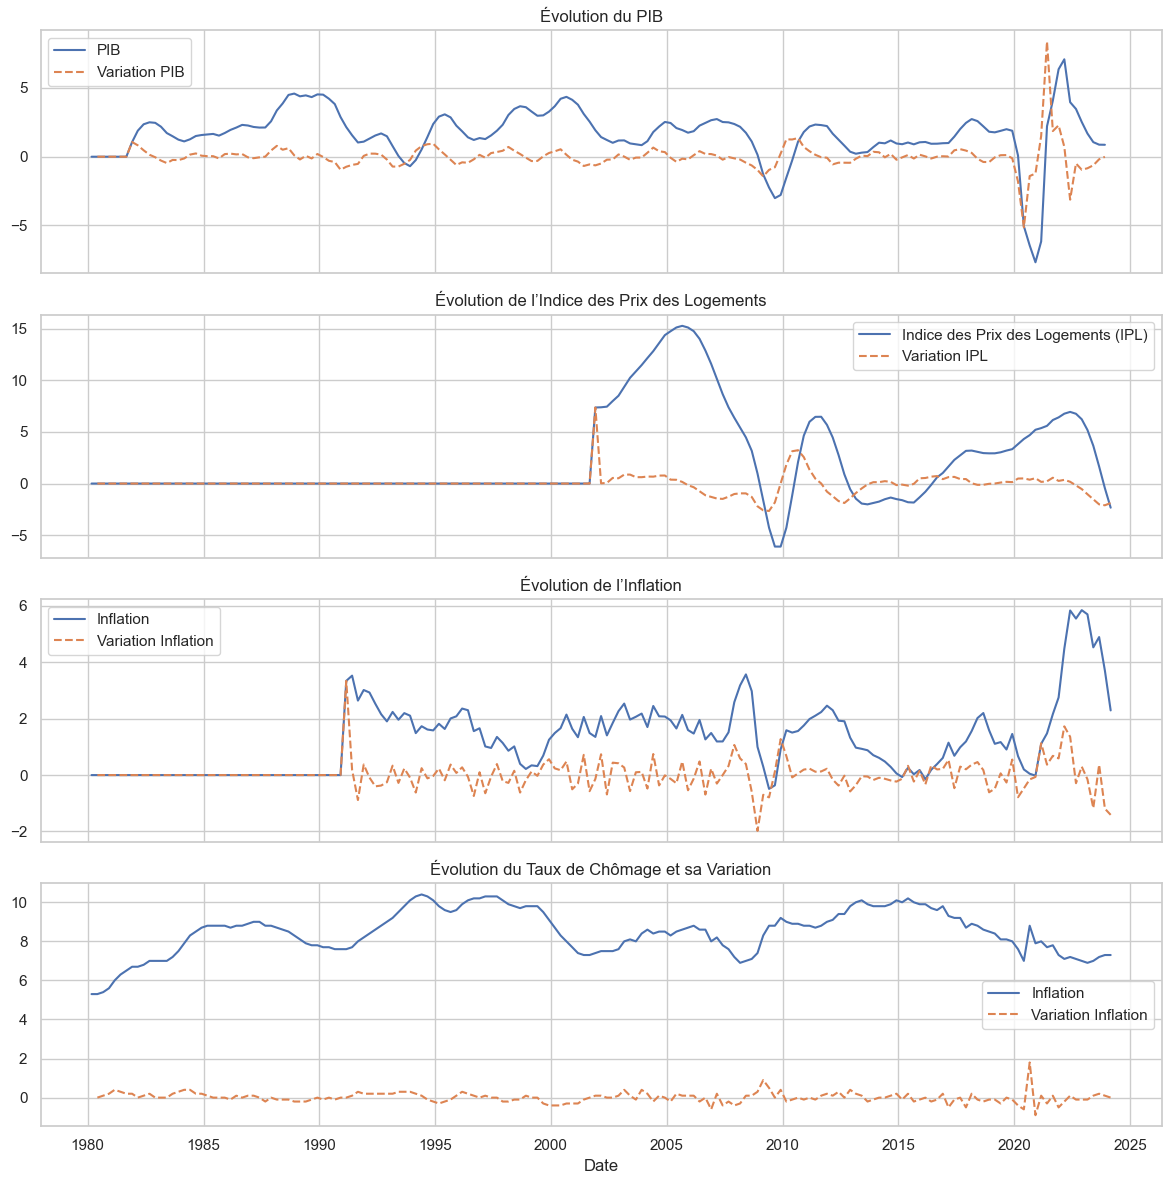

In [14]:
# Tracer PIB, IPL et Inflation avec leurs variations
fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

df_macro["date_dernier_mois"] = pd.to_datetime(df_macro["date_dernier_mois"])

# PIB
ax[0].plot(df_macro["date_dernier_mois"], df_macro["PIB"], label="PIB")
ax[0].plot(df_macro["date_dernier_mois"], df_macro["PIB_diff1"], label="Variation PIB", linestyle='--')
ax[0].set_title("Évolution du PIB")
ax[0].legend()
ax[0].grid(True)

# IPL
ax[1].plot(df_macro["date_dernier_mois"], df_macro["IPL"], label="Indice des Prix des Logements (IPL)" )
ax[1].plot(df_macro["date_dernier_mois"], df_macro["IPL_diff1"], label="Variation IPL", linestyle='--')
ax[1].set_title("Évolution de l’Indice des Prix des Logements")
ax[1].legend()
ax[1].grid(True)

# Inflation
ax[2].plot(df_macro["date_dernier_mois"], df_macro["Inflation"], label="Inflation")
ax[2].plot(df_macro["date_dernier_mois"], df_macro["Inflation_diff1"], label="Variation Inflation", linestyle='--')
ax[2].set_title("Évolution de l’Inflation")
ax[2].legend()
ax[2].grid(True)

# Inflation
ax[3].plot(df_macro["date_dernier_mois"], df_macro["TCH"], label="Inflation")
ax[3].plot(df_macro["date_dernier_mois"], df_macro["TCH_diff1"], label="Variation Inflation", linestyle='--')
ax[3].set_title("Évolution du Taux de Chômage et sa Variation")
ax[3].legend()
ax[3].grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()

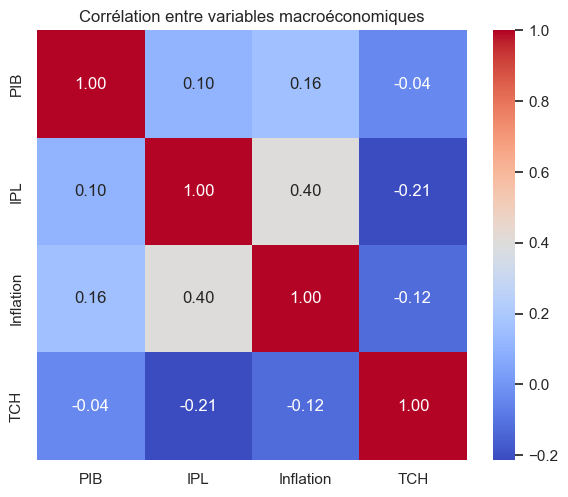

In [15]:
# Corrélation simple entre les 4 variables macro (en niveau)
simple_corr = df_macro[["PIB", "IPL", "Inflation", "TCH"]].corr()

# Tracer la heatmap de corrélation
plt.figure(figsize=(6, 5))
sns.heatmap(simple_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Corrélation entre variables macroéconomiques")
plt.tight_layout()
plt.show()

In [16]:
print(df_macro.head())

  date_dernier_mois  PIB  IPL  TCH  Inflation  PIB_diff1  IPL_diff1  \
0        1980-03-01  0.0  0.0  5.3        0.0        NaN        NaN   
1        1980-06-01  0.0  0.0  5.3        0.0        0.0        0.0   
2        1980-09-01  0.0  0.0  5.4        0.0        0.0        0.0   
3        1980-12-01  0.0  0.0  5.6        0.0        0.0        0.0   
4        1981-03-01  0.0  0.0  6.0        0.0        0.0        0.0   

   TCH_diff1  Inflation_diff1  
0        NaN              NaN  
1        0.0              0.0  
2        0.1              0.0  
3        0.2              0.0  
4        0.4              0.0  


## FORMATAGE

##### Mise à jour des dates 

In [17]:
# Créer une fonction de conversion fin → début de trimestre
def start_of_quarter(date):
    if date.month == 3:
        return pd.Timestamp(year=date.year, month=1, day=1)
    elif date.month == 6:
        return pd.Timestamp(year=date.year, month=4, day=1)
    elif date.month == 9:
        return pd.Timestamp(year=date.year, month=7, day=1)
    elif date.month == 12:
        return pd.Timestamp(year=date.year, month=10, day=1)
    else:
        return pd.NaT

# S'assurer que la colonne est au format datetime
df_macro["date_dernier_mois"] = pd.to_datetime(df_macro["date_dernier_mois"], errors='coerce')

# Appliquer la transformation sur df_macro
df_macro["date_dernier_mois"] = df_macro["date_dernier_mois"].apply(start_of_quarter)

In [18]:
# Reformatage : d'abord en string inversé, puis en datetime
df_macro["date_dernier_mois"] = df_macro["date_dernier_mois"].dt.strftime("%d-%m-%Y")
df_macro["date_dernier_mois"] = pd.to_datetime(df_macro["date_dernier_mois"], format="%d-%m-%Y")

# Filtrer les dates de l'année 2009 pour les deux DataFrames
dates_segment_2009 = df_segment[df_segment["date"].dt.year == 2009]["date"].unique()
dates_global_2009 = df_global[df_global["date"].dt.year == 2009]["date"].unique()
dates_macro_2009 = df_macro[df_macro["date_dernier_mois"].dt.year == 2009]["date_dernier_mois"].unique()

# Créer un tableau comparatif
df_dates_2009 = pd.DataFrame({
    "Dates df_global (2009)": dates_global_2009,
    "Dates df_segment (2009)": dates_segment_2009,
    "Dates df_macro (2009)": dates_macro_2009
})

print(df_dates_2009)

  Dates df_global (2009) Dates df_segment (2009) Dates df_macro (2009)
0             2009-01-01              2009-01-01            2009-01-01
1             2009-01-04              2009-04-01            2009-04-01
2             2009-01-07              2009-07-01            2009-07-01
3             2009-01-10              2009-10-01            2009-10-01


##### Segmenter les DF

In [19]:
# Créer un DataFrame par segment (valeur unique de note_ref)
segments_dfs = {
    f"segment_{segment}": df_segment[df_segment["note_ref"] == segment].reset_index(drop=True)
    for segment in sorted(df_segment["note_ref"].unique())
}

# Afficher les noms des segments et un aperçu d’un segment
segment_names = list(segments_dfs.keys())

segment_1 = segments_dfs[segment_names[0]]
segment_2 = segments_dfs[segment_names[1]]
segment_3 = segments_dfs[segment_names[2]]
segment_4 = segments_dfs[segment_names[3]]
segment_5 = segments_dfs[segment_names[4]]
segment_6 = segments_dfs[segment_names[5]]

### Merged avec MACRO 

In [20]:
df_macro_lag = df_macro.copy()

df_macro_lag['PIB_lag1'] = df_macro['PIB'].shift(1)
df_macro_lag['IPL_lag1'] = df_macro['IPL_diff1'].shift(1)
df_macro_lag['Inflation_lag1'] = df_macro['Inflation_diff1'].shift(1)
df_macro_lag['TCH_lag1'] = df_macro['TCH_diff1'].shift(1)

# # Pivot pour obtenir les colonnes Indicateur_moyen_Brut_1 à 6
# pivot_df = df_segment.pivot(index="date", columns="note_ref", values=["Indicateur_moyen_Brut", "PourcNoteCohorte"])
# pivot_df.columns = [f"Indicateur_moyen_Brut_{int(col)}" for col in pivot_df.columns]

# Pivot pour transformer les colonnes par segment (note_ref)
pivot_df = df_segment.pivot(index="date", columns="note_ref", values=["Indicateur_moyen_Brut", "PourcNoteCohorte5"])

# Aplatir les colonnes multi-index
pivot_df.columns = [f"{var}_{int(note)}" for var, note in pivot_df.columns]

# (optionnel) Réinitialiser l’index si tu veux une colonne date
# pivot_df = pivot_df.reset_index()

# Fusionner avec les données macroéconomiques
df_macro_lag = df_macro_lag.rename(columns={"date_dernier_mois": "date"})
df_merged = pivot_df.merge(df_macro_lag, on="date", how="left")

# Créer une copie sans la colonne Indicateur_moyen_Brut_6
df_merged_6 = df_merged.drop(columns=["Indicateur_moyen_Brut_6"], inplace=False)

# Définir "date" comme index
df_merged.set_index("date", inplace=True)

# Afficher un aperçu des données fusionnées
print(df_merged.head())

            Indicateur_moyen_Brut_1  Indicateur_moyen_Brut_2  \
date                                                           
2009-01-01                 0.451963                 0.918515   
2009-04-01                 0.598795                 0.693970   
2009-07-01                 0.460212                 0.676645   
2009-10-01                 0.431518                 0.697949   
2010-01-01                 0.302710                 0.681718   

            Indicateur_moyen_Brut_3  Indicateur_moyen_Brut_4  \
date                                                           
2009-01-01                 0.919843                 1.275864   
2009-04-01                 0.840965                 0.967390   
2009-07-01                 0.868909                 1.052081   
2009-10-01                 0.974173                 0.936315   
2010-01-01                 0.849149                 1.168515   

            Indicateur_moyen_Brut_5  Indicateur_moyen_Brut_6  \
date                                  

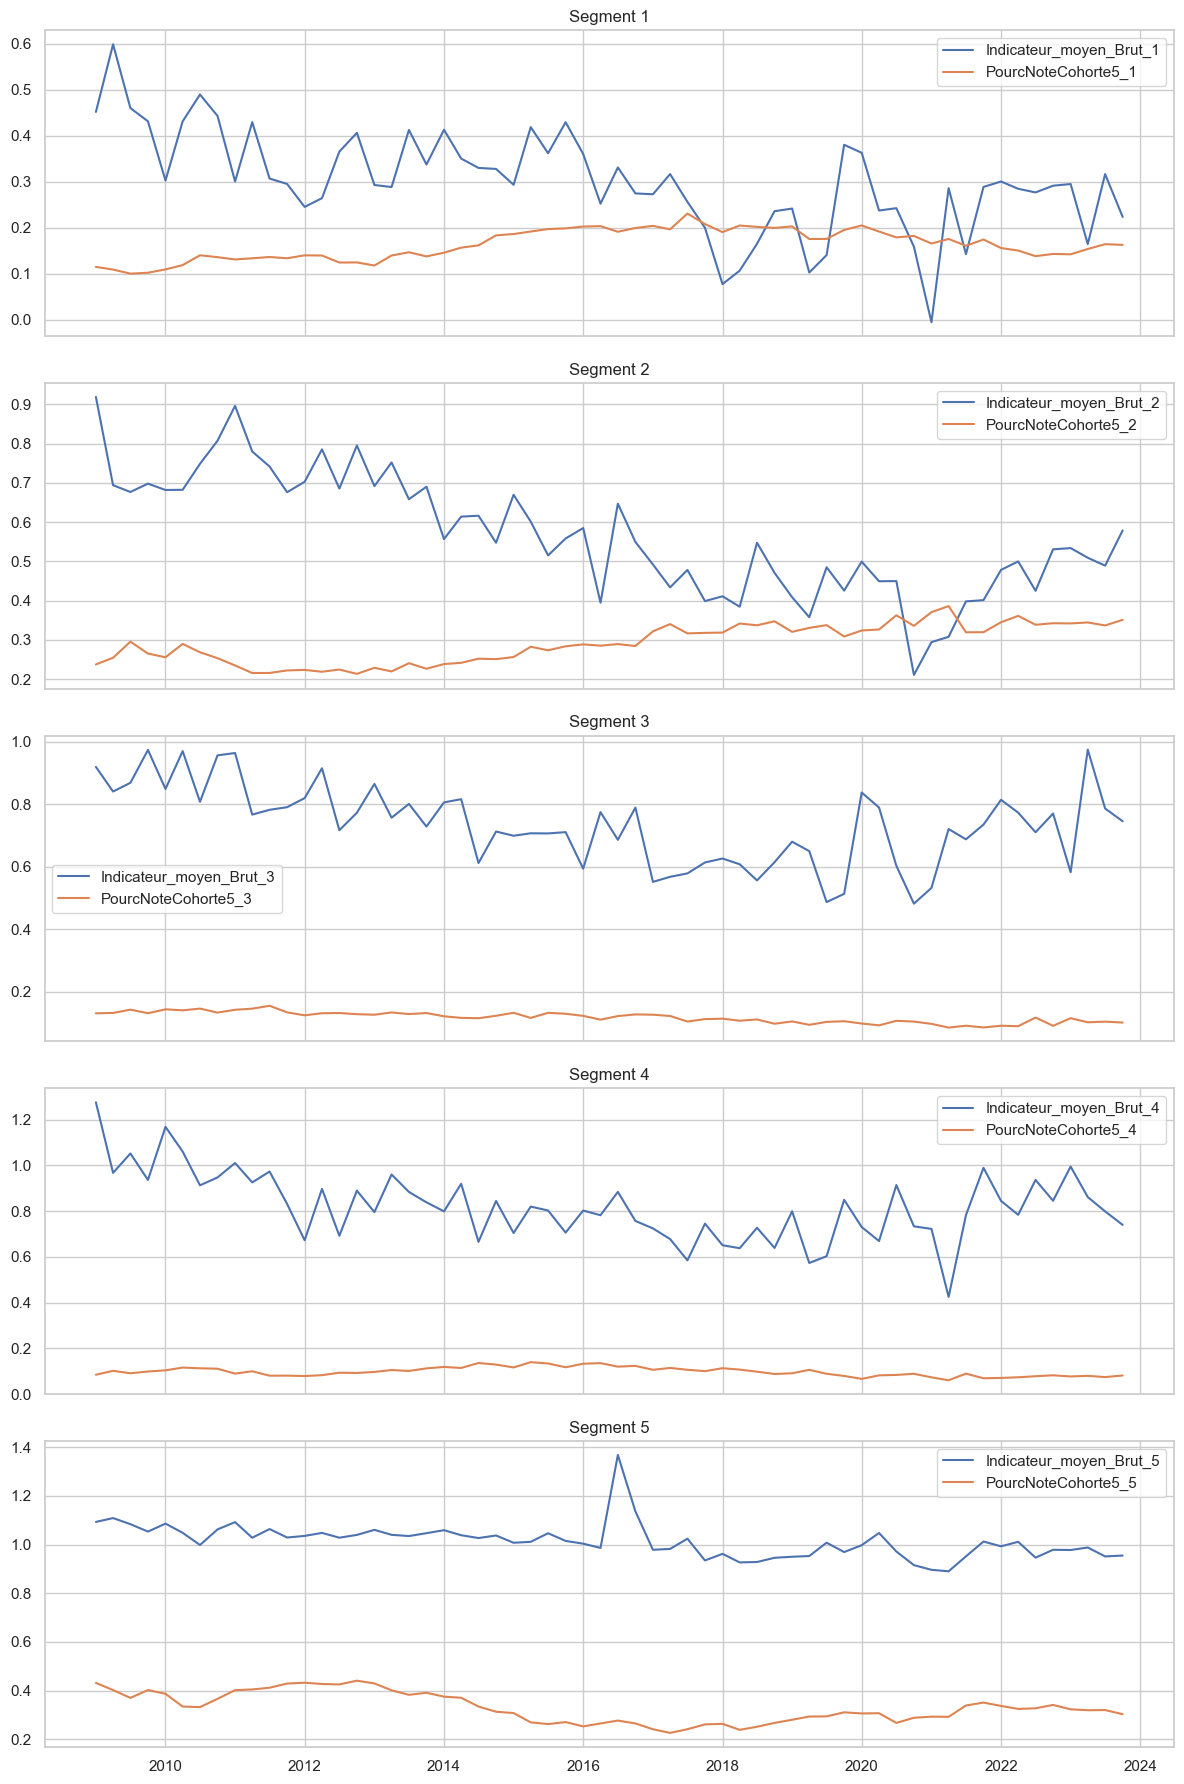

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Création des subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 18), sharex=True)

for i in range(1, 6):
    ax = axes[i-1]
    ax.plot(df_merged.index, df_merged[f'Indicateur_moyen_Brut_{i}'], label=f'Indicateur_moyen_Brut_{i}')
    ax.plot(df_merged.index, df_merged[f'PourcNoteCohorte5_{i}'], label=f'PourcNoteCohorte5_{i}')
    ax.set_title(f'Segment {i}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

## ANALYSE

### GLOBAL

#### Autocorrelation

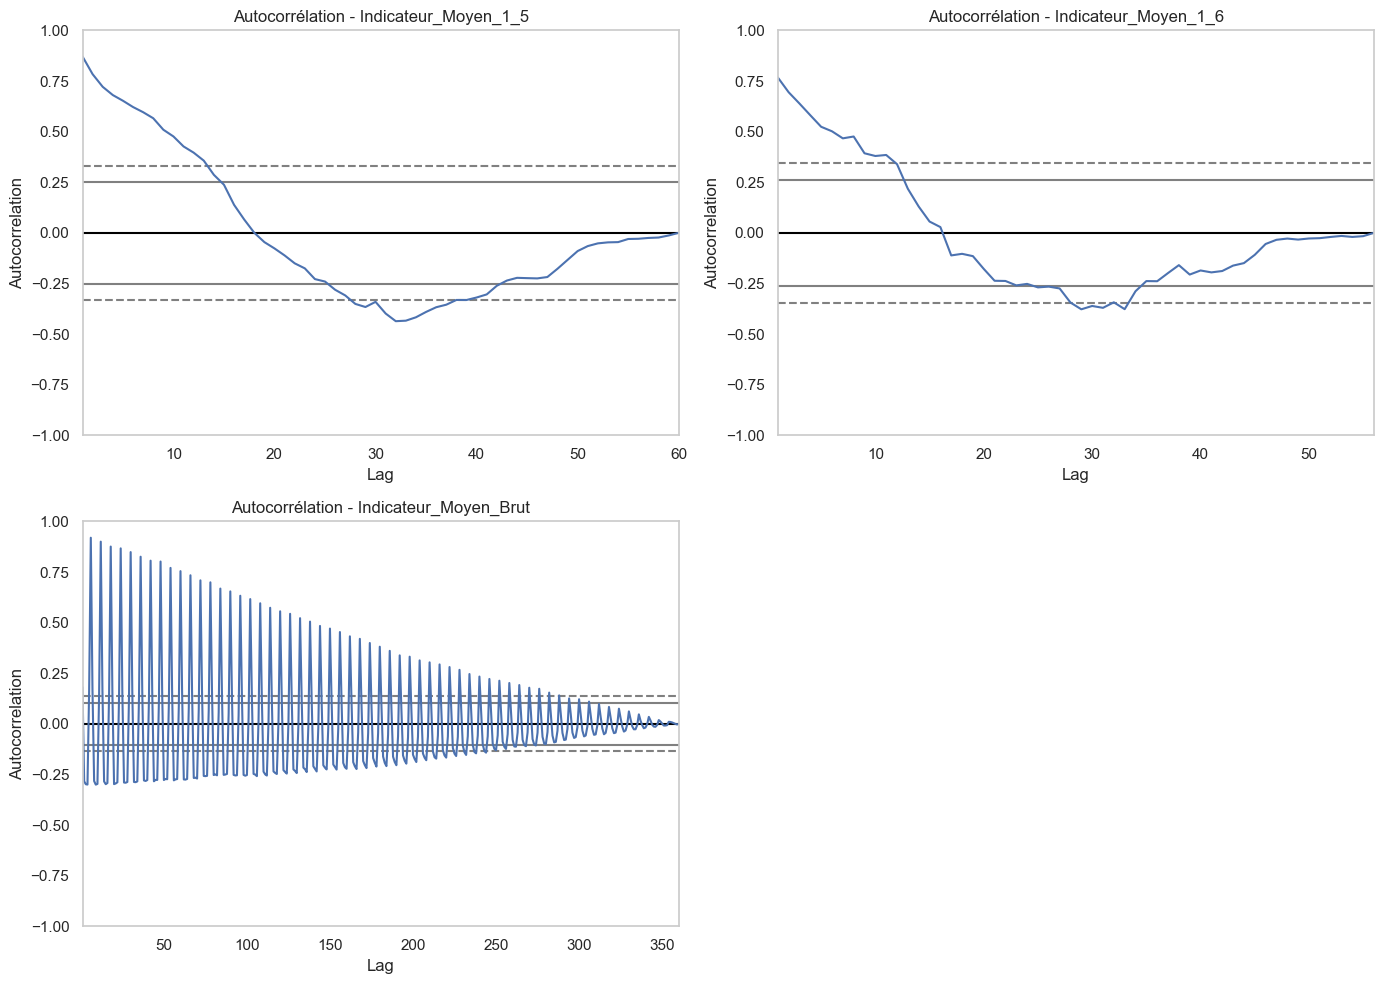

In [22]:
# Tracer les autocorrélations
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
autocorrelation_plot(df_global["Indicateur_Moyen_1_5"].dropna())
plt.title("Autocorrélation - Indicateur_Moyen_1_5")

plt.subplot(2, 2, 2)
autocorrelation_plot(df_global["Indicateur_Moyen_1_6"].dropna())
plt.title("Autocorrélation - Indicateur_Moyen_1_6")

plt.subplot(2, 2, 3)
autocorrelation_plot(df_segment["Indicateur_moyen_Brut"].dropna())
plt.title("Autocorrélation - Indicateur_Moyen_Brut")


plt.tight_layout()
plt.show()

#### Stationnarité

In [23]:
# Appliquer les tests ADF en utilisant les bons DataFrames pour chaque série

# Création de dictionnaires d'entrée
series_sources = {
    "Indicateur_Moyen_1_5": df_global["Indicateur_Moyen_1_5"].dropna(),  # df_global
    "Indicateur_Moyen_1_6": df_global["Indicateur_Moyen_1_6"].dropna(),  # df_global
    "Indicateur_Moyen_Brut": df_segment["Indicateur_moyen_Brut"].dropna()  # df_segmentdf_segment["Indicateur_moyen_Brut"].dropna() df_segment["Indicateur_moyen_Brut"].dropna()  #  # df_segment
}
# Lancer le test ADF
adf_results_corrected = []

for name, series in series_sources.items():
    adf = adfuller(series)
    adf_results_corrected.append({
        "Série": name,
        "ADF Statistic": adf[0],
        "p-value": adf[1],
        "Critique 1%": adf[4]['1%'],
        "Critique 5%": adf[4]['5%'],
        "Critique 10%": adf[4]['10%']
    })

adf_df_corrected = pd.DataFrame(adf_results_corrected)
adf_df_corrected

Série  ADF Statistic   p-value  Critique 1%  Critique 5%  \
0   Indicateur_Moyen_1_5      -2.371826  0.149847    -3.546395    -2.911939   
1   Indicateur_Moyen_1_6      -2.128698  0.233133    -3.557709    -2.916770   
2  Indicateur_Moyen_Brut      -2.053515  0.263612    -3.449616    -2.870028   

   Critique 10%  
0     -2.593652  
1     -2.596222  
2     -2.571292

#### Règles de stationnarité

p-value > 0.05, donc on ne rejette pas l’hypothèse nulle :


👉 pas stationnaire au seuil de 5%.


Statistique ADF > valeur critique à 5%,

👉 pas stationnaire au seuil de 5%.

### Par segment

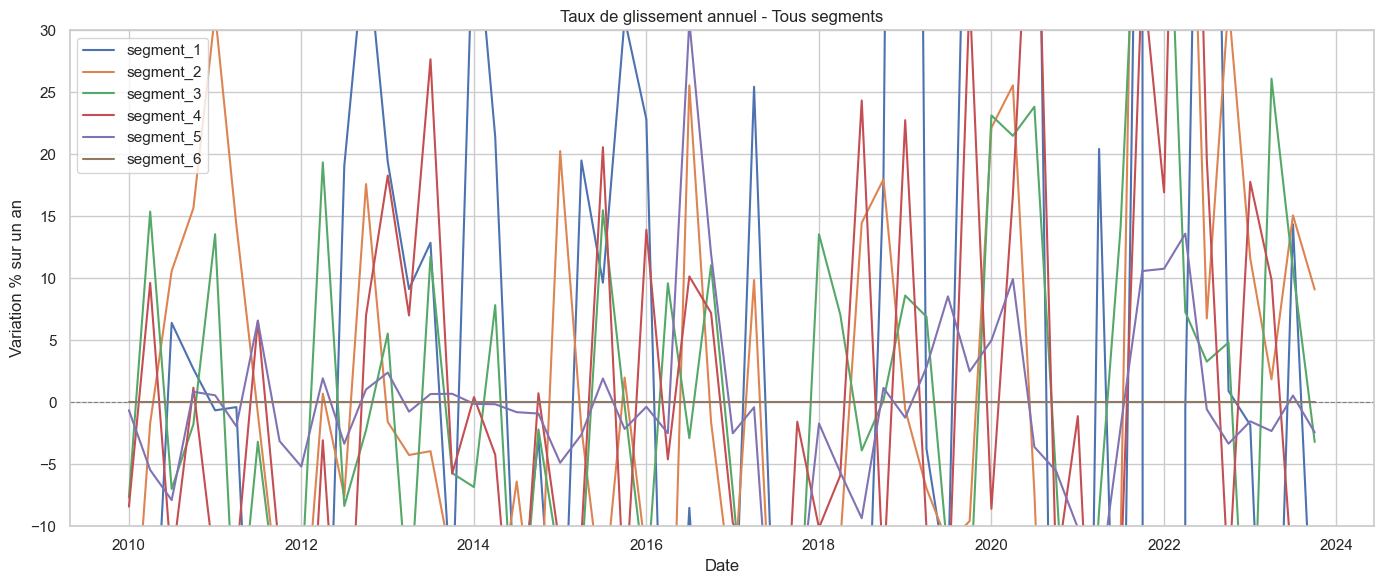

In [24]:
# Réimporter bibliothèques nécessaires après reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calcul du glissement annuel pour tous les segments
glissement_annuel_dfs = {}
for name, df in segments_dfs.items():
    df_sorted = df.sort_values("date").reset_index(drop=True).copy()
    df_sorted["glissement_annuel"] = (df_sorted["Indicateur_moyen_Brut"] / df_sorted["Indicateur_moyen_Brut"].shift(4) - 1) * 100
    glissement_annuel_dfs[name] = df_sorted.dropna().reset_index(drop=True)

# Tracer toutes les séries de glissement annuel sur une seule grille
plt.figure(figsize=(14, 6))
for name, df in glissement_annuel_dfs.items():
    plt.plot(df["date"], df["glissement_annuel"], label=name)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Taux de glissement annuel - Tous segments")
plt.xlabel("Date")
plt.ylabel("Variation % sur un an")
plt.ylim(-10, 30)
plt.legend()
plt.tight_layout()
plt.show()

segment_1 60
segment_2 60
segment_3 60
segment_4 60
segment_5 60
segment_6 60


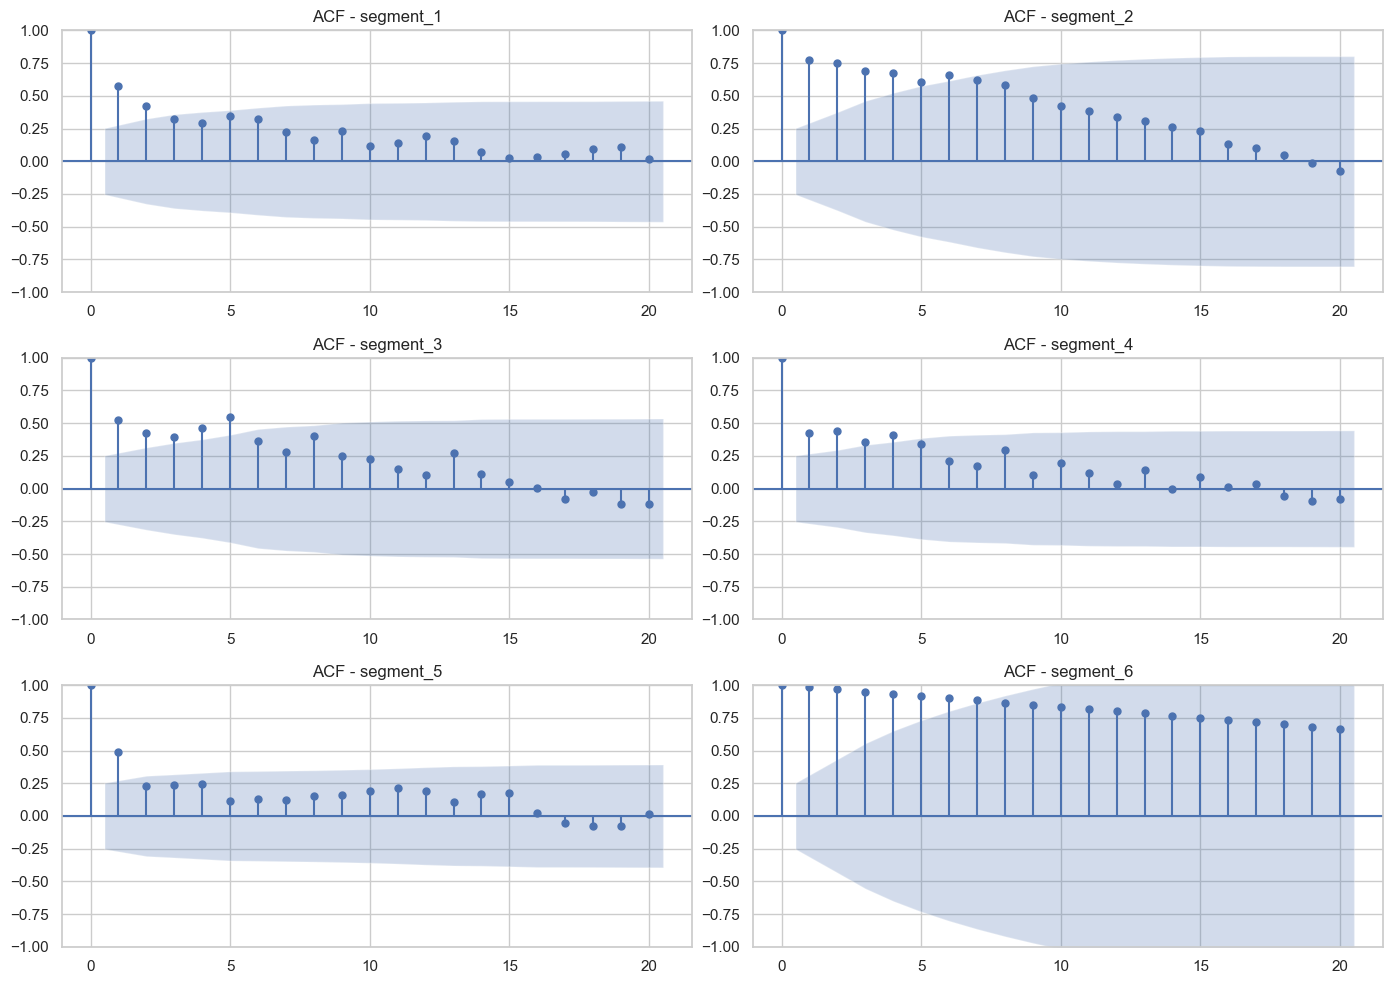

Segment  ADF Statistic   p-value  Critique 1%  Critique 5%  Critique 10%
0  segment_1      -3.983272  0.001501    -3.546395    -2.911939     -2.593652
1  segment_2      -1.833660  0.363883    -3.548494    -2.912837     -2.594129
2  segment_3      -2.228654  0.196010    -3.565624    -2.920142     -2.598015
3  segment_4      -5.324879  0.000005    -3.546395    -2.911939     -2.593652
4  segment_5      -4.430622  0.000262    -3.546395    -2.911939     -2.593652
5  segment_6            NaN       NaN          NaN          NaN           NaN

In [25]:
# Utiliser segment_names et segments_dfs directement, avec vérification du nombre d'observations

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# Initialiser résultats
adf_results = []

# Créer la grille de sous-graphiques
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()
plot_index = 0

for name in segment_names:
    print(name, len(segments_dfs[name]["Indicateur_moyen_Brut"].dropna()))

# Itérer sur les noms de segments existants
for name in segment_names:
    df = segments_dfs[name]
    series = df["Indicateur_moyen_Brut"].dropna()

    # Tester la taille de la série avant de tracer l'ACF
    if len(series) > 20:
        plot_acf(series, ax=axes[plot_index], lags=20, alpha=0.05)
        axes[plot_index].set_title(f"ACF - {name}")
        plot_index += 1

    # Effectuer le test ADF même si la série est courte
    try:
        adf = adfuller(series)
        adf_results.append({
            "Segment": name,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]["1%"],
            "Critique 5%": adf[4]["5%"],
            "Critique 10%": adf[4]["10%"]
        })
    except:
        adf_results.append({
            "Segment": name,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None
        })

# Supprimer les axes inutilisés
for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Créer un tableau des résultats ADF
adf_df = pd.DataFrame(adf_results)
adf_df

| Segment   | ACF persistante | ADF p-value | Stationnaire ? | Action recommandée  |
| --------- | --------------- | ----------- | -------------- | ------------------- |
| Segment 1 | Moyenne         | 0.0015      | ✅ Oui          | OK                  |
| Segment 2 | Forte           | 0.36        | ❌ Non          | Différencier        |
| Segment 3 | Moyenne à forte | 0.196       | ❌ Non          | Différencier        |
| Segment 4 | Moyenne         | 0.000005    | ✅ Oui          | OK                  |
| Segment 5 | Faible          | 0.00026     | ✅ Oui          | OK                  |
| Segment 6 | Très forte      | NaN         | ❓ Invalide     | Vérifier / nettoyer |


### Pour les MACRO

In [26]:
# Filtrer les données de df_macro de 2009 à aujourd'hui
df_macro = df_macro[df_macro['date_dernier_mois'] >= '2009-01-01']

# Afficher un aperçu des données filtrées
print(df_macro)

    date_dernier_mois       PIB       IPL  TCH  Inflation  PIB_diff1  \
116        2009-01-01 -1.286788 -1.624415  8.3   0.301692  -1.430885   
117        2009-04-01 -2.243102 -4.278729  8.8  -0.489570  -0.956314   
118        2009-07-01 -3.012266 -6.103516  8.8  -0.362976  -0.769164   
119        2009-10-01 -2.782833 -6.105367  9.2   0.914470   0.229433   
120        2010-01-01 -1.517665 -4.278209  9.0   1.589859   1.265167   
..                ...       ...       ...  ...        ...        ...   
172        2023-01-01  1.687226  5.190174  6.9   5.701873  -0.838929   
173        2023-04-01  1.061365  3.664003  7.0   4.531319  -0.625860   
174        2023-07-01  0.876149  1.650038  7.2   4.896221  -0.185217   
175        2023-10-01  0.868858 -0.455149  7.3   3.705326  -0.007291   
176        2024-01-01       NaN -2.335217  7.3   2.294717        NaN   

     IPL_diff1  TCH_diff1  Inflation_diff1  
116  -2.593841        0.9        -0.697982  
117  -2.654313        0.5        -0.791262  


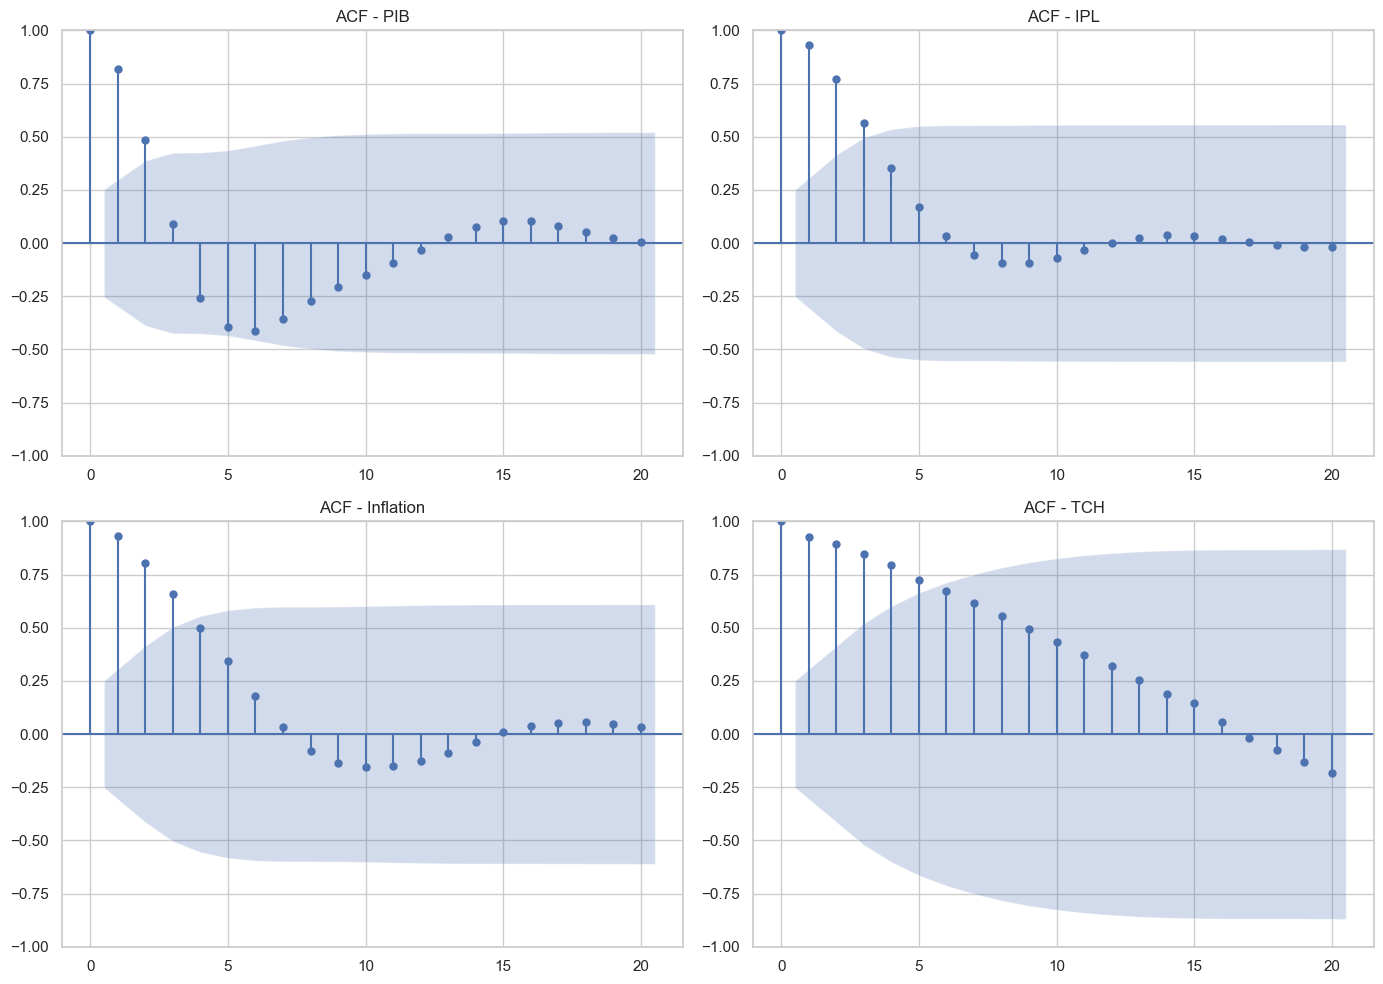

Variable  ADF Statistic   p-value  Critique 1%  Critique 5%  Critique 10%
0        PIB      -3.327967  0.013674    -3.571472    -2.922629     -2.599336
1        IPL      -1.542183  0.512550    -3.568486    -2.921360     -2.598662
2  Inflation      -1.320889  0.619562    -3.562879    -2.918973     -2.597393
3        TCH      -0.270556  0.929572    -3.546395    -2.911939     -2.593652

In [27]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt

# Initialiser les résultats
adf_results_macro = []

# Créer la grille de sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
plot_index = 0

# Itérer sur les variables macroéconomiques
for var in ["PIB", "IPL", "Inflation", "TCH"]:
    series = df_macro[var].dropna()

    # Tracer l'ACF
    plot_acf(series, ax=axes[plot_index], lags=20, alpha=0.05)
    axes[plot_index].set_title(f"ACF - {var}")
    plot_index += 1

    # Effectuer le test ADF
    try:
        adf = adfuller(series)
        adf_results_macro.append({
            "Variable": var,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]["1%"],
            "Critique 5%": adf[4]["5%"],
            "Critique 10%": adf[4]["10%"]
        })
    except Exception as e:
        adf_results_macro.append({
            "Variable": var,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None,
            "Erreur": str(e)
        })

plt.tight_layout()
plt.show()

# Créer un tableau des résultats ADF
adf_df_macro = pd.DataFrame(adf_results_macro)
adf_df_macro

*| Variable      | Stationnarité (Test ADF) | ACF Interprétation       | Conclusion           |
| ------------- | ------------------------ | ------------------------ | -------------------- |
| **PIB**       | Stationnaire (5%)        | Décroissance rapide      |    |
| **IPL**       | Stationnaire (5%)        | Décroissance lente       |   |
| **Inflation** | Stationnaire (5%)        | Décroissance progressive |          |
| **TCH**       | Non stationnaire (5%)    | Persistance élevée       | **À différencier**   |
*

| Variable      | ADF Stat. | p-value | Stationnaire ? | Action à prévoir         |
| ------------- | --------- | ------- | -------------- | ------------------------ |
| **PIB**       | -3.33     | 0.0137  | ✅ Oui (5%)     | Utilisable en l'état     |
| **IPL**       | -1.54     | 0.5126  | ❌ Non          | Appliquer une différence |
| **Inflation** | -1.32     | 0.6196  | ❌ Non          | Appliquer une différence |
| **TCH**       | -0.27     | 0.9296  | ❌ Non          | Appliquer une différence |


## Différenciation

In [28]:
# # Différencier la série temporelle et refaire ADF
# df_global['Indicateur_Moyen_1_5_diff'] = df_global['Indicateur_Moyen_1_5'].diff()

# adf_global = adfuller(df_global['Indicateur_Moyen_1_5_diff'].dropna())
# adf_result = {
#     'ADF Statistic': adf_global[0],
#     'p-value': adf_global[1],
#     'Critical Values': adf_global[4]
# }

# # Résultat du test ADF
# adf_df = pd.DataFrame([adf_result], index=['Indicateur_Moyen_1_5_diff'])
# print("\nRésultat du test ADF:")
# print(adf_df)

### taux de variation

##### Global

In [29]:
# Réimporter les bibliothèques nécessaires après le reset
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Reconstituer les séries simulées (comme dans l'étape précédente)
np.random.seed(42)
dates = pd.date_range(start="2009-01-01", periods=60, freq="Q")
ind_1_5 = np.random.normal(loc=0.71, scale=0.12, size=60)
ind_1_6 = np.random.normal(loc=0.86, scale=0.055, size=60)
ind_bruit = np.cumsum(np.random.normal(loc=0.02, scale=0.05, size=60)) + 0.75

df_autocorr = pd.DataFrame({
    "date": dates,
    "Indicateur_Moyen_1_5": ind_1_5,
    "Indicateur_Moyen_1_6": ind_1_6,
    "Indicateur_Moyen_Brut": ind_bruit
})

# Calcul du taux de variation logarithmique
log_diff_results = {
    "Indicateur_Moyen_1_5": np.log(df_autocorr["Indicateur_Moyen_1_5"]).diff().dropna(),
    "Indicateur_Moyen_1_6": np.log(df_autocorr["Indicateur_Moyen_1_6"]).diff().dropna(),
    "Indicateur_Moyen_Brut": np.log(df_autocorr["Indicateur_Moyen_Brut"]).diff().dropna()
}

# Appliquer le test ADF
adf_logdiff_results = []

for name, series in log_diff_results.items():
    series = series.replace([np.inf, -np.inf], np.nan).dropna()
    adf = adfuller(series)
    adf_logdiff_results.append({
        "Série (log_diff)": name,
        "ADF Statistic": adf[0],
        "p-value": adf[1],
        "Critique 1%": adf[4]['1%'],
        "Critique 5%": adf[4]['5%'],
        "Critique 10%": adf[4]['10%']
    })

df_adf_logdiff = pd.DataFrame(adf_logdiff_results)

display(df_adf_logdiff)

C:\Users\dumas\AppData\Local\Temp\ipykernel_42620\2975679586.py:8: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(start="2009-01-01", periods=60, freq="Q")


Série (log_diff)  ADF Statistic       p-value  Critique 1%  \
0   Indicateur_Moyen_1_5      -6.907378  1.237275e-09    -3.555273   
1   Indicateur_Moyen_1_6      -8.127519  1.112825e-12    -3.555273   
2  Indicateur_Moyen_Brut     -10.701609  3.511681e-19    -3.548494   

   Critique 5%  Critique 10%  
0    -2.915731     -2.595670  
1    -2.915731     -2.595670  
2    -2.912837     -2.594129

##### Par segment

Avec LOG_DIFF

In [30]:
# Recharger bibliothèques après reset
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Appliquer log.diff() et tester la stationnarité
segments_to_transform = ["segment_2", "segment_3"]
tv_results = []

for name in segments_to_transform:
    series = segments_dfs[name]["Indicateur_moyen_Brut"]
    series_log_diff = np.log(series).diff().dropna()
    
    try:
        adf = adfuller(series_log_diff)
        tv_results.append({
            "Segment (log diff)": name,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]['1%'],
            "Critique 5%": adf[4]['5%'],
            "Critique 10%": adf[4]['10%']
        })
    except:
        tv_results.append({
            "Segment (log diff)": name,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None
        })

df_tv_adf = pd.DataFrame(tv_results)
print(df_tv_adf)

  Segment (log diff)  ADF Statistic   p-value  Critique 1%  Critique 5%  \
0          segment_2      -5.251563  0.000007    -3.557709    -2.916770   
1          segment_3      -2.863254  0.049791    -3.565624    -2.920142   

   Critique 10%  
0     -2.596222  
1     -2.598015  


Avec Hodrick-Prescott

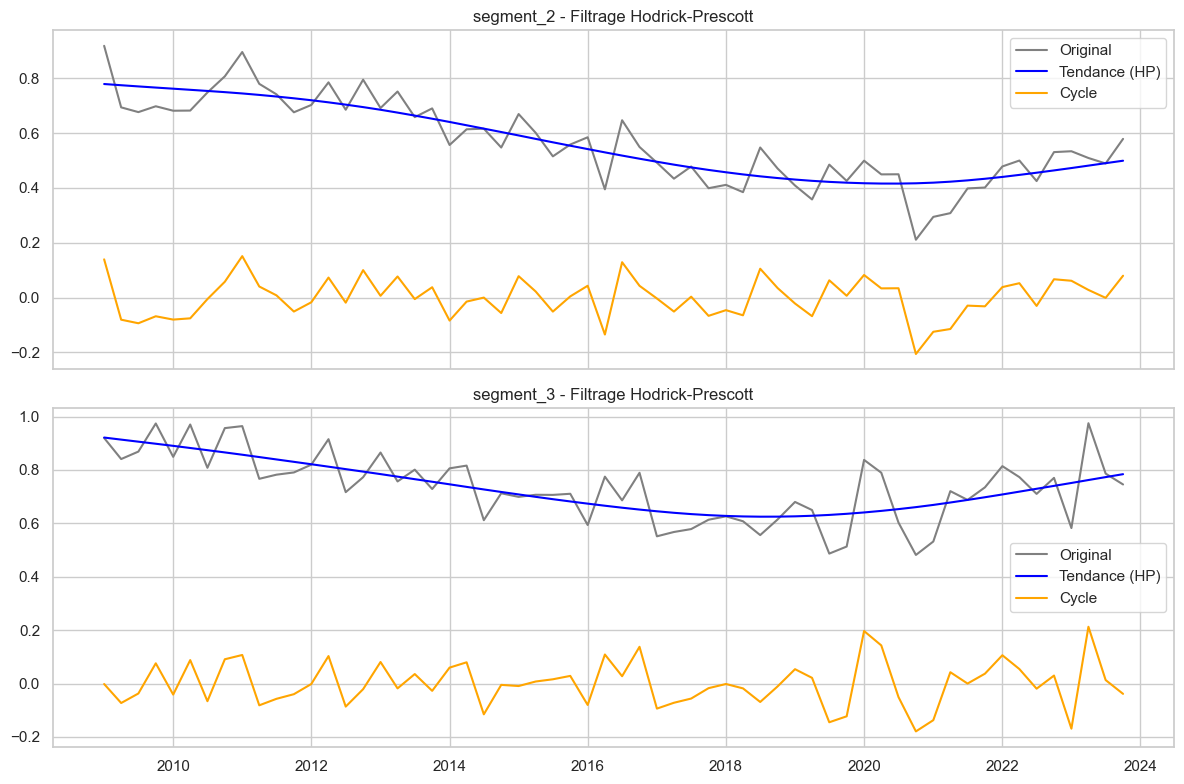

In [31]:
import pandas as pd
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt

# Appliquer le filtre HP à chaque série non stationnaire
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for i, name in enumerate(["segment_2", "segment_3"]):
    df = segments_dfs[name]
    cycle, trend = hpfilter(df["Indicateur_moyen_Brut"], lamb=1600)
    df["trend"] = trend
    df["cycle"] = cycle

    # Tracer
    axes[i].plot(df["date"], df["Indicateur_moyen_Brut"], label="Original", color='gray')
    axes[i].plot(df["date"], df["trend"], label="Tendance (HP)", color='blue')
    axes[i].plot(df["date"], df["cycle"], label="Cycle", color='orange')
    axes[i].set_title(f"{name} - Filtrage Hodrick-Prescott")
    axes[i].legend()

plt.tight_layout()
plt.show()

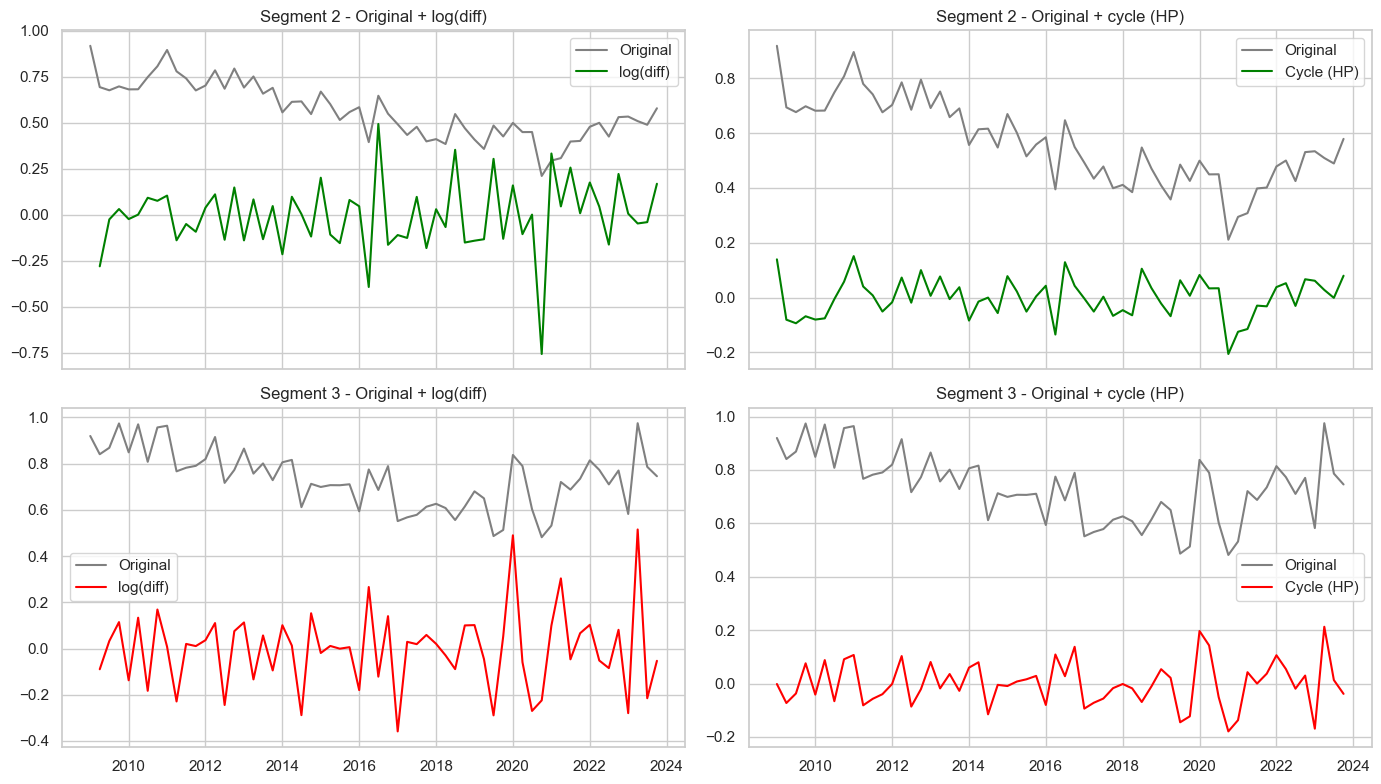

In [32]:
# Recalculer les séries stationnarisées par log.diff() pour segment_2 et segment_3
logdiff_dfs = {}
hp_cycle_dfs = {}

for name in ["segment_2", "segment_3"]:
    df = segments_dfs[name].copy()

    # Méthode log.diff()
    df_logdiff = df[["date", "Indicateur_moyen_Brut"]].copy()
    df_logdiff["log_diff"] = np.log(df_logdiff["Indicateur_moyen_Brut"]).diff()
    logdiff_dfs[name] = df_logdiff.dropna().reset_index(drop=True)

    # Méthode HP filter
    cycle, trend = hpfilter(df["Indicateur_moyen_Brut"], lamb=1600)
    df_hp = df[["date"]].copy()
    df_hp["cycle"] = cycle
    hp_cycle_dfs[name] = df_hp.reset_index(drop=True)

# Ajouter les séries originales à côté des séries stationnarisées pour comparaison visuelle

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

# Segment 2
axes[0, 0].plot(segments_dfs["segment_2"]["date"], segments_dfs["segment_2"]["Indicateur_moyen_Brut"], label="Original", color="gray")
axes[0, 0].plot(logdiff_dfs["segment_2"]["date"], logdiff_dfs["segment_2"]["log_diff"], label="log(diff)", color="green")
axes[0, 0].set_title("Segment 2 - Original + log(diff)")
axes[0, 0].legend()

axes[0, 1].plot(segments_dfs["segment_2"]["date"], segments_dfs["segment_2"]["Indicateur_moyen_Brut"], label="Original", color="gray")
axes[0, 1].plot(hp_cycle_dfs["segment_2"]["date"], hp_cycle_dfs["segment_2"]["cycle"], label="Cycle (HP)", color="green")
axes[0, 1].set_title("Segment 2 - Original + cycle (HP)")
axes[0, 1].legend()

# Segment 3
axes[1, 0].plot(segments_dfs["segment_3"]["date"], segments_dfs["segment_3"]["Indicateur_moyen_Brut"], label="Original", color="gray")
axes[1, 0].plot(logdiff_dfs["segment_3"]["date"], logdiff_dfs["segment_3"]["log_diff"], label="log(diff)", color="red")
axes[1, 0].set_title("Segment 3 - Original + log(diff)")
axes[1, 0].legend()

axes[1, 1].plot(segments_dfs["segment_3"]["date"], segments_dfs["segment_3"]["Indicateur_moyen_Brut"], label="Original", color="gray")
axes[1, 1].plot(hp_cycle_dfs["segment_3"]["date"], hp_cycle_dfs["segment_3"]["cycle"], label="Cycle (HP)", color="red")
axes[1, 1].set_title("Segment 3 - Original + cycle (HP)")
axes[1, 1].legend()

plt.tight_layout()
plt.show()



| Segment   | Meilleure méthode                                           |
| --------- | ----------------------------------------------------------- |
| Segment 2 | **HP filter** ✅ (plus régulier, moins bruité)               |
| Segment 3 | **log(diff)** ✅ (meilleure réactivité, structure conservée) |


#### Rechecker la stationnarité :

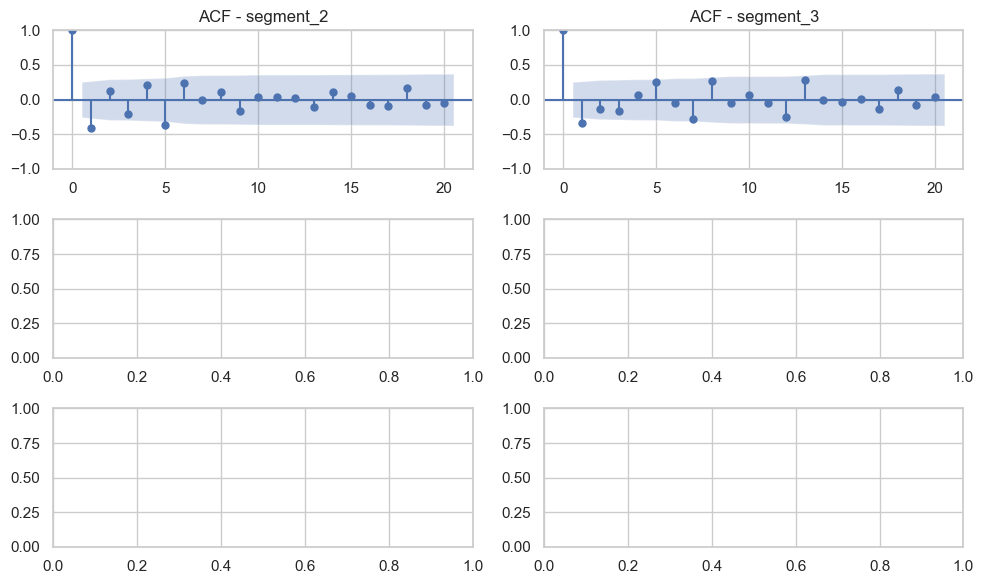

NameError: name 'df_adf_summary' is not defined

In [33]:
# Recharger les bibliothèques nécessaires
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Préparer les séries finales pour ADF et ACF :
# segment_1, segment_4, segment_5, segment_6 → brut
# segment_2 → logdiff
# segment_3 → HP cycle
series_finales = {}

# Segment 2 → log diff
series_finales["segment_2"] = logdiff_dfs["segment_2"]["log_diff"].dropna()

# Segment 3 → HP cycle
#series_finales["segment_3"] = hp_cycle_dfs["segment_3"]["cycle"].dropna()

# Segment 3 → log diff
series_finales["segment_3"] = logdiff_dfs["segment_3"]["log_diff"].dropna()


# Calculer ADF et tracer ACF
adf_results = []
fig, axes = plt.subplots(3, 2, figsize=(10, 6))
axes = axes.flatten()

for i, (name, serie) in enumerate(series_finales.items()):
    # ADF test
    try:
        adf = adfuller(serie)
        adf_results.append({
            "Segment": name,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]["1%"],
            "Critique 5%": adf[4]["5%"],
            "Critique 10%": adf[4]["10%"]
        })
    except:
        adf_results.append({
            "Segment": name,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None
        })

    # Plot ACF
    plot_acf(serie, ax=axes[i], lags=20, alpha=0.05)
    axes[i].set_title(f"ACF - {name}")

plt.tight_layout()
plt.show()

display(df_adf_summary)

# Visualisation série après formatage : 

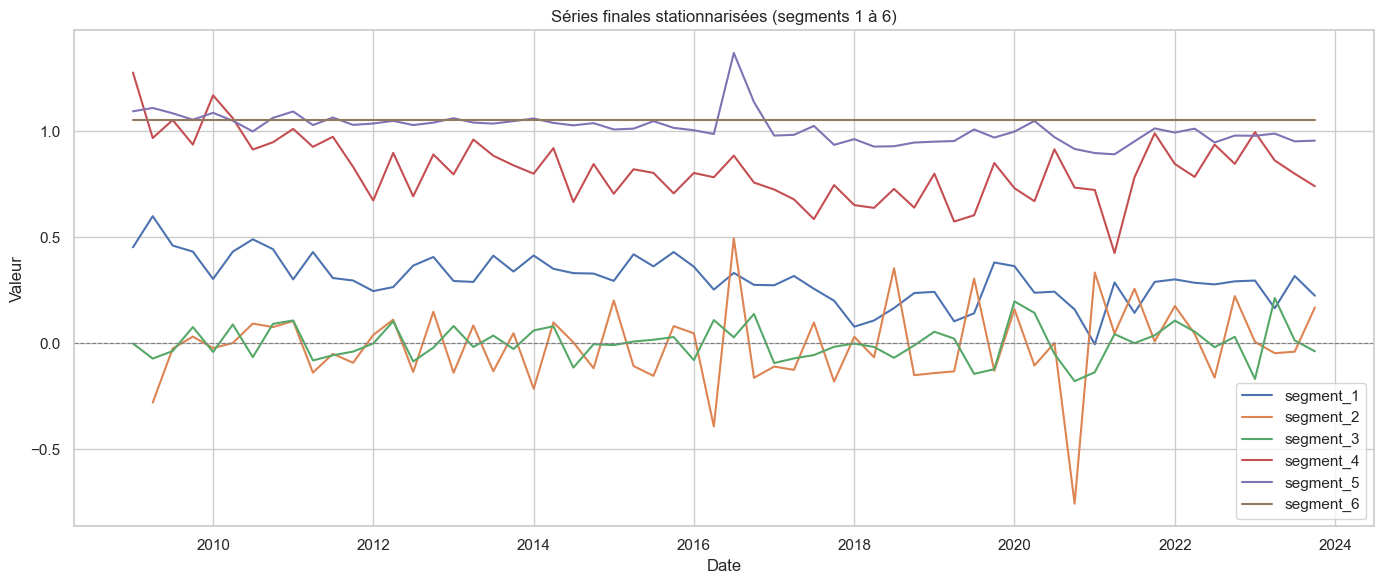

In [34]:
# Recréer les transformations nécessaires pour segment_2 (log diff) et segment_3 (HP cycle)
from statsmodels.tsa.filters.hp_filter import hpfilter

# Log diff pour segment_2
segment_2 = segments_dfs["segment_2"].copy()
logdiff_dfs = {
    "segment_2": segment_2[["date", "Indicateur_moyen_Brut"]].copy()
}
logdiff_dfs["segment_2"]["log_diff"] = np.log(logdiff_dfs["segment_2"]["Indicateur_moyen_Brut"]).diff()

# HP cycle pour segment_3
segment_3 = segments_dfs["segment_3"].copy()
cycle, trend = hpfilter(segment_3["Indicateur_moyen_Brut"], lamb=1600)
hp_cycle_dfs = {
    "segment_3": pd.DataFrame({
        "date": segment_3["date"],
        "cycle": cycle
    })
}

# Recréer series_finales à partir des segments disponibles
series_finales = {
    "segment_1": segments_dfs["segment_1"][["date", "Indicateur_moyen_Brut"]],
    "segment_2": logdiff_dfs["segment_2"][["date", "log_diff"]].rename(columns={"log_diff": "Indicateur_moyen_Brut"}).dropna(),
    "segment_3": hp_cycle_dfs["segment_3"][["date", "cycle"]].rename(columns={"cycle": "Indicateur_moyen_Brut"}),
    "segment_4": segments_dfs["segment_4"][["date", "Indicateur_moyen_Brut"]],
    "segment_5": segments_dfs["segment_5"][["date", "Indicateur_moyen_Brut"]],
    "segment_6": segments_dfs["segment_6"][["date", "Indicateur_moyen_Brut"]],
}

# Tracer toutes les séries sur une même grille
plt.figure(figsize=(14, 6))
for name, df in series_finales.items():
    plt.plot(df["date"], df["Indicateur_moyen_Brut"], label=name)

plt.title("Séries finales stationnarisées (segments 1 à 6)")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()

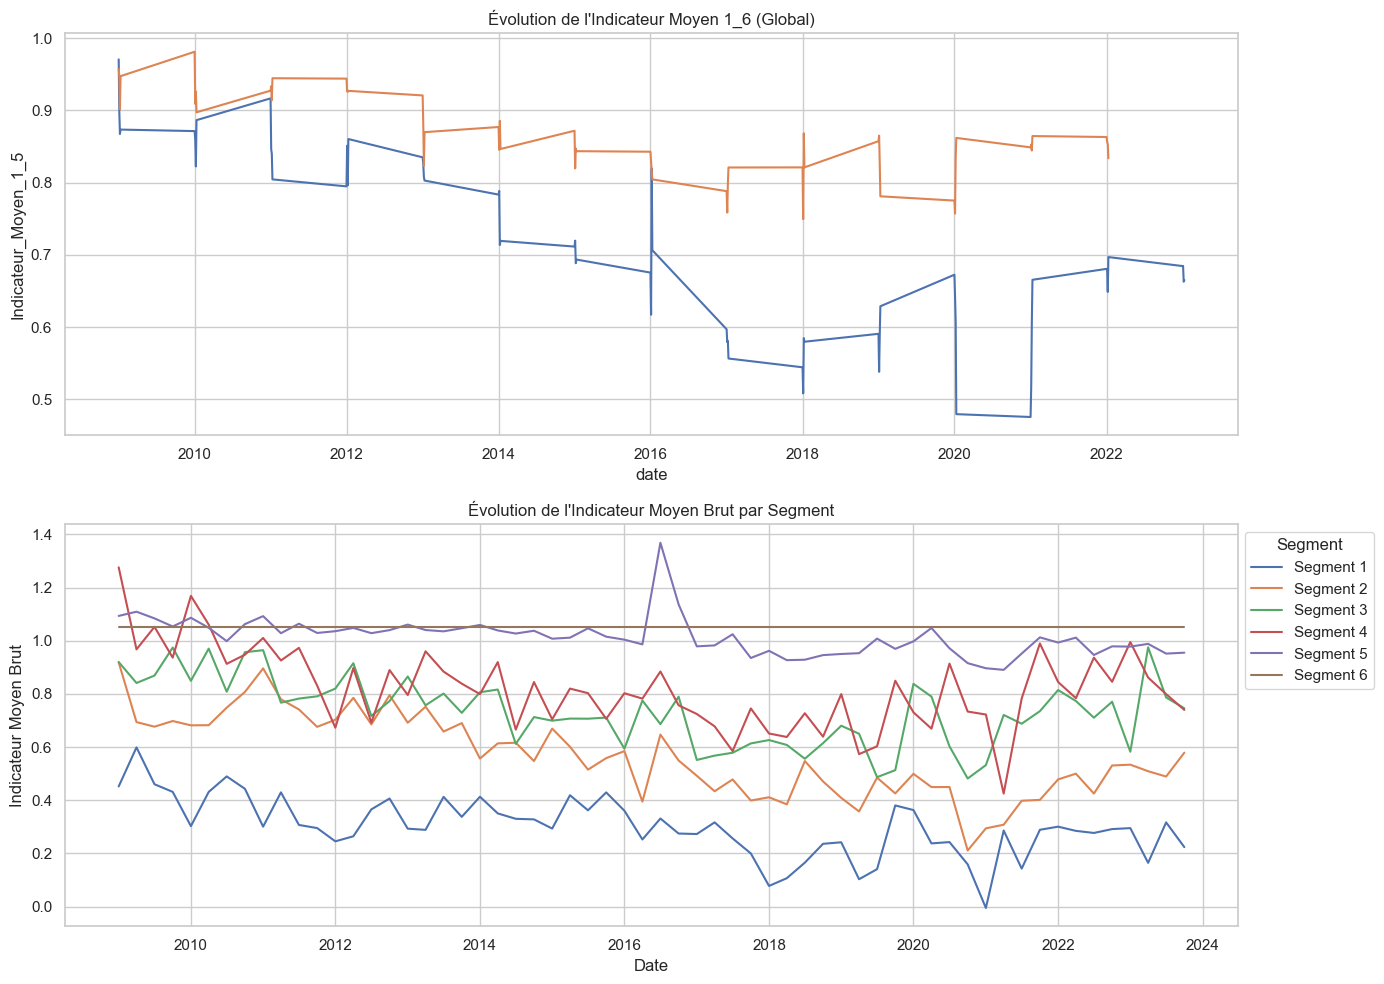

In [35]:
# Segments avec données brutes
for seg in ["segment_1", "segment_4", "segment_5", "segment_6"]:
    if seg in segments_dfs:
        series_finales[seg] = segments_dfs[seg]["Indicateur_moyen_Brut"].dropna()

# Segment 2 → log diff
series_finales["segment_2"] = logdiff_dfs["segment_2"]["log_diff"].dropna()

# Segment 3 → HP cycle
series_finales["segment_3"] = hp_cycle_dfs["segment_3"]["cycle"].dropna()


# Visualisations
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Global CCF 1_5
sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_5', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_5 (Global)")

sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_6', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_6 (Global)")


# Plusieurs segments superposés avec légende
for i in range(0, 6):
    segment = df_segment['note_ref'].unique()[i]
    df_plot_seg = df_segment[df_segment['note_ref'] == segment]
    sns.lineplot(
        data=df_plot_seg,
        x='date',
        y='Indicateur_moyen_Brut',
        ax=axs[1],
        label=f"Segment {segment}"
    )

axs[1].set_title("Évolution de l'Indicateur Moyen Brut par Segment")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Indicateur Moyen Brut")
axs[1].legend(title="Segment", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()



## ANALYSE DES SERIES 

In [36]:
df_merged.drop(columns=["Indicateur_moyen_Brut_6"], inplace=True)

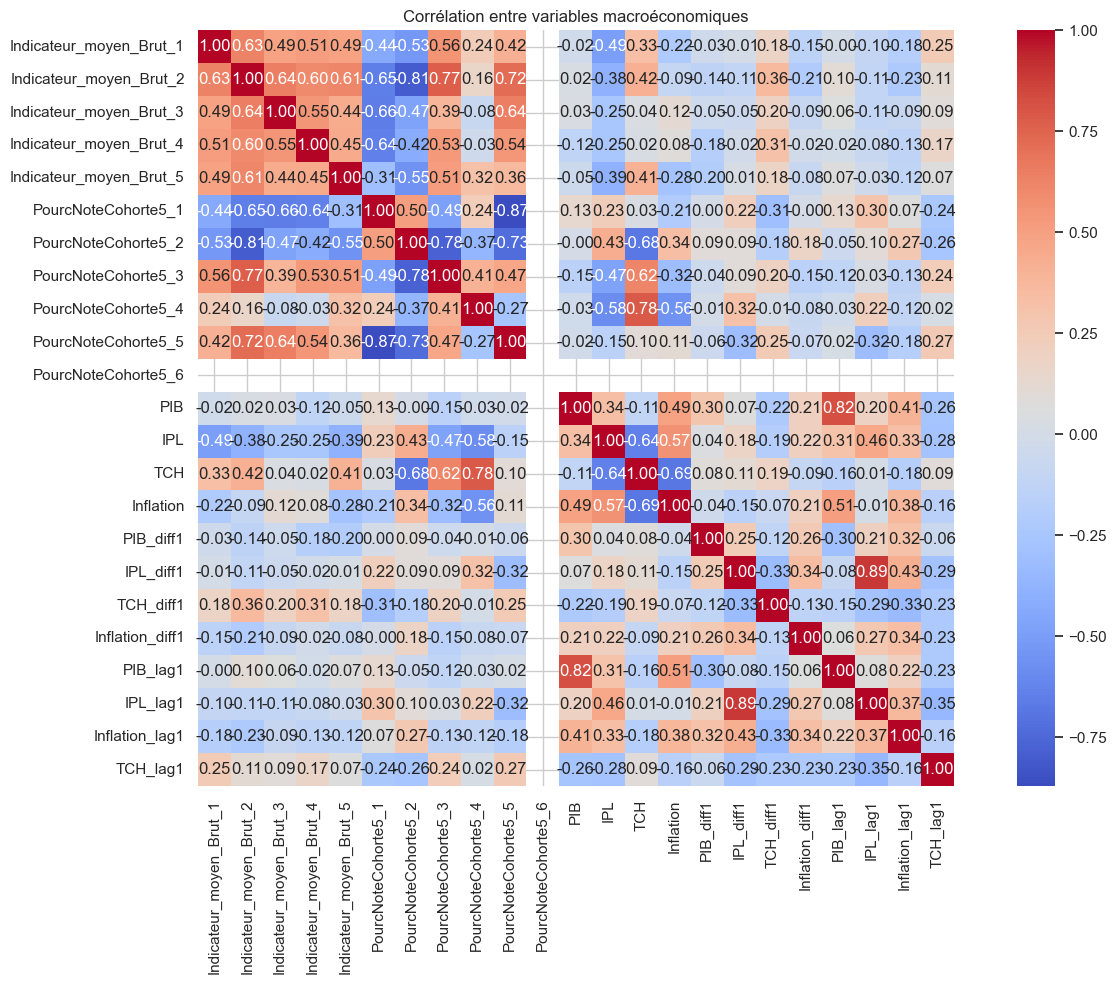

In [37]:
# Calcul de la matrice de corrélation complète
correlation_matrix = df_merged.corr()

# Tracer la heatmap de corrélation
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Corrélation entre variables macroéconomiques")
plt.tight_layout()
plt.show()

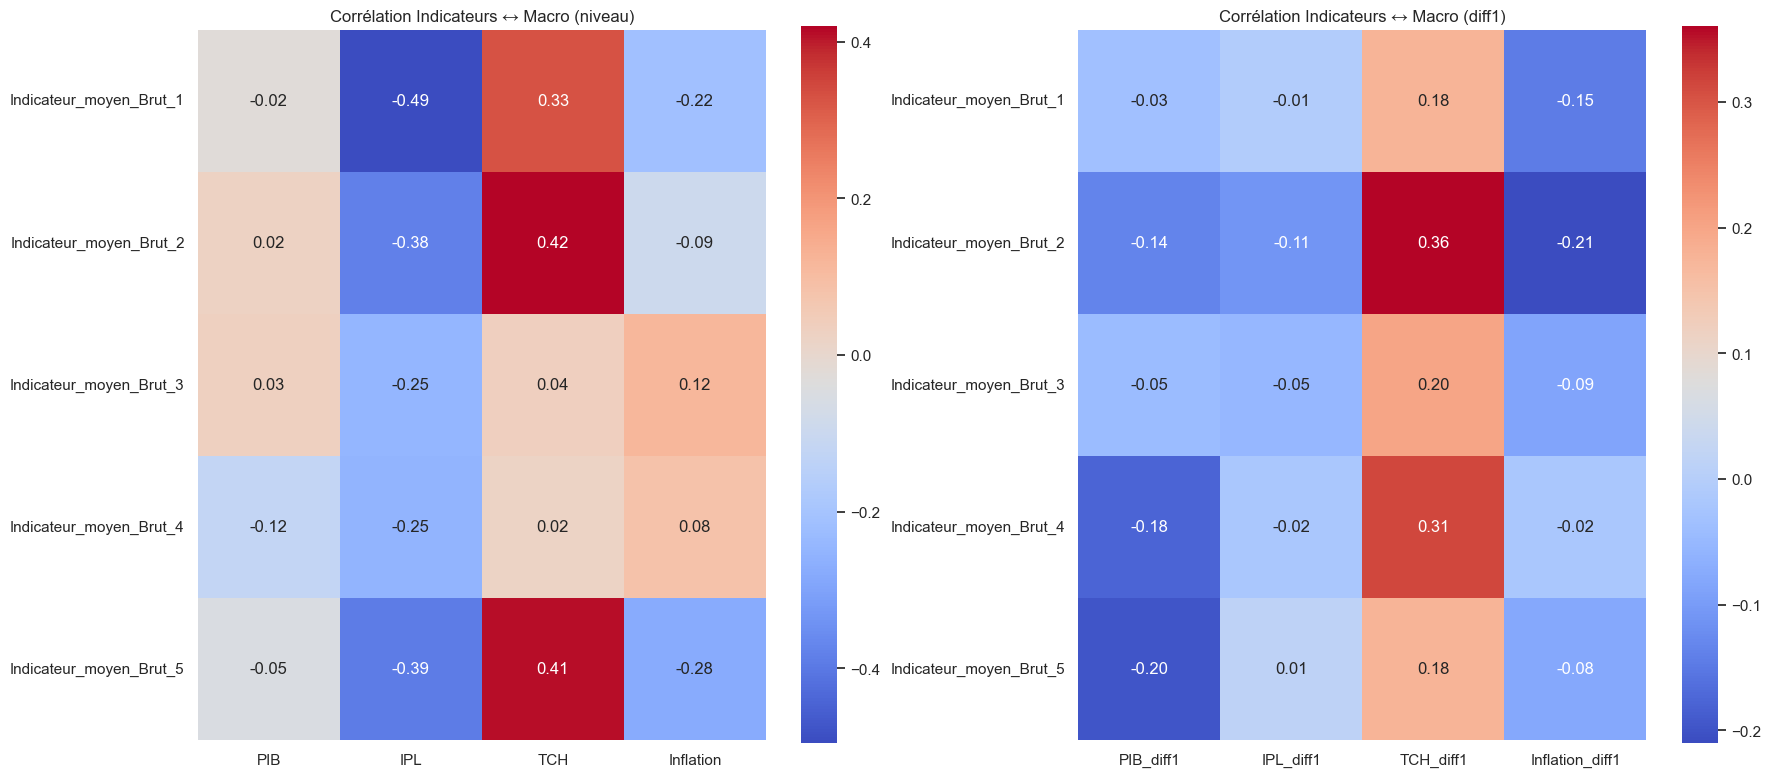

In [38]:
# Sélectionner uniquement les colonnes "Indicateur" et variables macro (niveau + diff1)
cols_indicateur = [col for col in df_merged.columns if col.startswith("Indicateur")]
cols_macro = ["PIB", "IPL", "TCH", "Inflation"]
cols_macro_diff = ["PIB_diff1", "IPL_diff1", "TCH_diff1", "Inflation_diff1"]

# Corrélation entre Indicateurs et valeurs macro
correlation_macro = df_merged[cols_indicateur + cols_macro].corr().loc[cols_indicateur, cols_macro]

# Corrélation entre Indicateurs et variations macro (diff1)
correlation_macro_diff = df_merged[cols_indicateur + cols_macro_diff].corr().loc[cols_indicateur, cols_macro_diff]

# Tracer les deux heatmaps sur des subplots côte à côte
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Corrélation macro niveau
sns.heatmap(correlation_macro, annot=True, fmt=".2f", cmap="coolwarm", square=True, ax=axes[0])
axes[0].set_title("Corrélation Indicateurs ↔ Macro (niveau)")

# Corrélation macro variations (diff1)
sns.heatmap(correlation_macro_diff, annot=True, fmt=".2f", cmap="coolwarm", square=True, ax=axes[1])
axes[1].set_title("Corrélation Indicateurs ↔ Macro (diff1)")

plt.tight_layout()
plt.show()

# Modelisation


### TEST DES HYPOTHESES DU MCO :

In [39]:
df = df_merged.copy()

print(df.head())

print(df.info())

            Indicateur_moyen_Brut_1  Indicateur_moyen_Brut_2  \
date                                                           
2009-01-01                 0.451963                 0.918515   
2009-04-01                 0.598795                 0.693970   
2009-07-01                 0.460212                 0.676645   
2009-10-01                 0.431518                 0.697949   
2010-01-01                 0.302710                 0.681718   

            Indicateur_moyen_Brut_3  Indicateur_moyen_Brut_4  \
date                                                           
2009-01-01                 0.919843                 1.275864   
2009-04-01                 0.840965                 0.967390   
2009-07-01                 0.868909                 1.052081   
2009-10-01                 0.974173                 0.936315   
2010-01-01                 0.849149                 1.168515   

            Indicateur_moyen_Brut_5  PourcNoteCohorte5_1  PourcNoteCohorte5_2  \
date                 

| Hypothèse                                                | Objectif                                                                            | Comment tester ?                                           | Graphique utile ?                     | Test statistique                  |
| -------------------------------------------------------- | ----------------------------------------------------------------------------------- | ---------------------------------------------------------- | ------------------------------------- | --------------------------------- |
| **1. Linéarité**                                         | La relation entre Y et X est linéaire                                               | - Résidus vs prédictions : doit être aléatoire, sans motif | ✅ OUI (essentiel)                     | Pas nécessaire                    |
| **2. Indépendance des erreurs**                          | Les erreurs ne doivent pas être autocorrélées                                       | - ACF des résidus<br>- Test de Durbin-Watson ≈ 2           | ✅ OUI (utile)                         | ✅ Durbin-Watson                   |
| **3. Homoscédasticité** (variance constante des erreurs) | Pas de structure dans la variance des erreurs                                       | - Résidus vs prédictions : doit être horizontal            | ✅ OUI (essentiel)                     | ✅ Breusch-Pagan                   |
| **4. Normalité des résidus**                             | Les résidus doivent être normalement distribués pour valider les tests statistiques | - Histogramme avec KDE<br>- QQ-plot                        | ✅ OUI (utile)                         | ✅ Shapiro-Wilk<br>✅ Jarque-Bera   |
| **5. Non-colinéarité entre les X**                       | Les variables explicatives ne doivent pas être trop corrélées entre elles           | - Matrice de corrélation<br>- Calcul des VIF               | 🚫 (pas un graphique sur les résidus) | ✅ VIF (Variance Inflation Factor) |


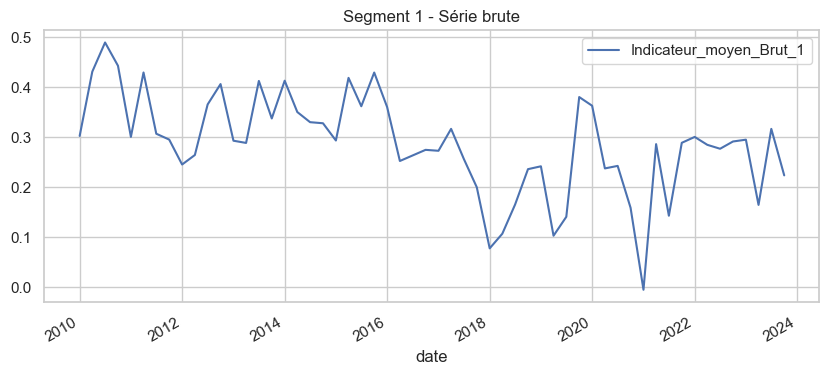

In [54]:
df[["Indicateur_moyen_Brut_1"]].plot(figsize=(10,4), title="Segment 1 - Série brute")
plt.grid(True)
plt.show()


Features: ['PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1', 'PIB_lag1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1', 'PIB_lag2', 'TCH_ma3', 'Inflation_ma3', 'PIB_x_TCH'] | AIC: -83.78 | R²: 0.263 | Max p: 0.806 | Max VIF: 14.06
Features: ['PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1', 'PIB_lag1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1', 'PIB_lag2', 'TCH_ma3', 'PIB_x_TCH'] | AIC: -85.70 | R²: 0.262 | Max p: 0.595 | Max VIF: 14.05
Features: ['PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1', 'PIB_lag1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1', 'PIB_lag2', 'TCH_ma3'] | AIC: -87.33 | R²: 0.257 | Max p: 0.526 | Max VIF: 11.06
Features: ['PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1', 'PIB_lag2', 'TCH_ma3'] | AIC: -88.82 | R²: 0.250 | Max p: 0.477 | Max VIF: 9.47
Features: ['PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1', 'PIB_lag2'] | AIC: -90.19 | R²: 0.241 | Max p: 0.343 | Max VIF: 9.16
Feat

Segment      R²     AIC  \
0  Indicateur_moyen_Brut_1  0.0351  -91.47   
1  Indicateur_moyen_Brut_2  0.4471  -77.26   
2  Indicateur_moyen_Brut_3  0.0572  -74.32   
3  Indicateur_moyen_Brut_4  0.3503  -91.25   
4  Indicateur_moyen_Brut_5  0.3651 -182.60   

                        Variables sélectionnées  
0                                            []  
1       [PIB, IPL_lag1, TCH_ma3, Inflation_ma3]  
2                                            []  
3                 [PIB_lag1, IPL_lag1, TCH_ma3]  
4  [PIB_lag1, IPL_lag1, TCH_ma3, Inflation_ma3]

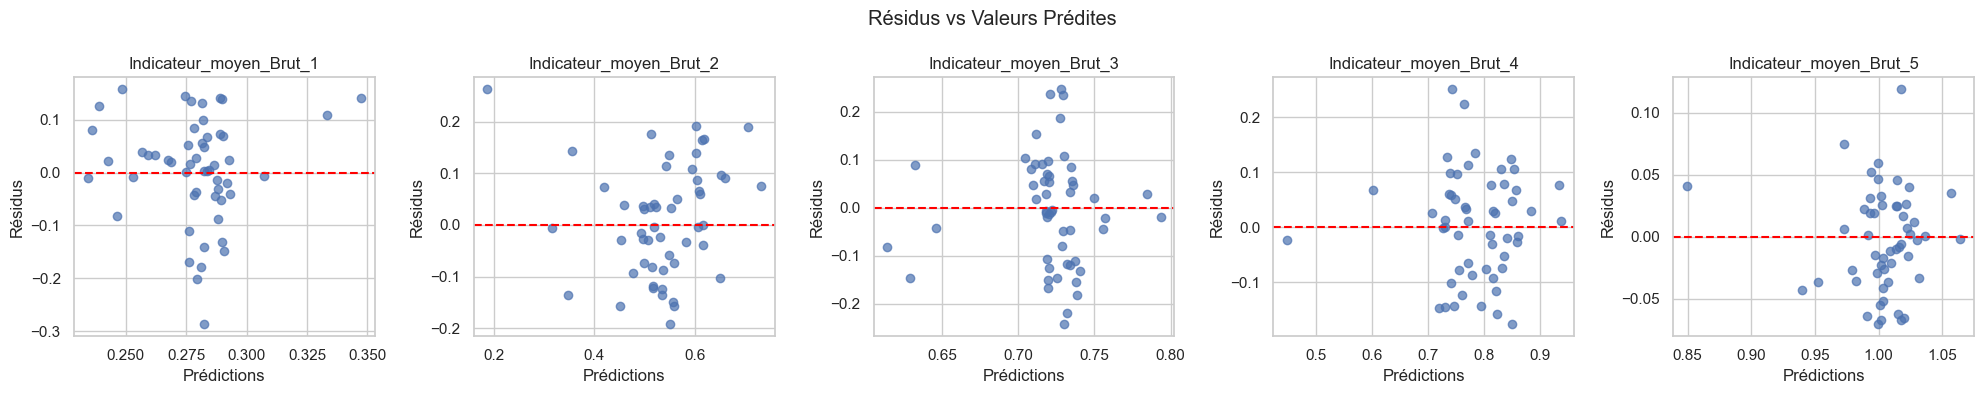

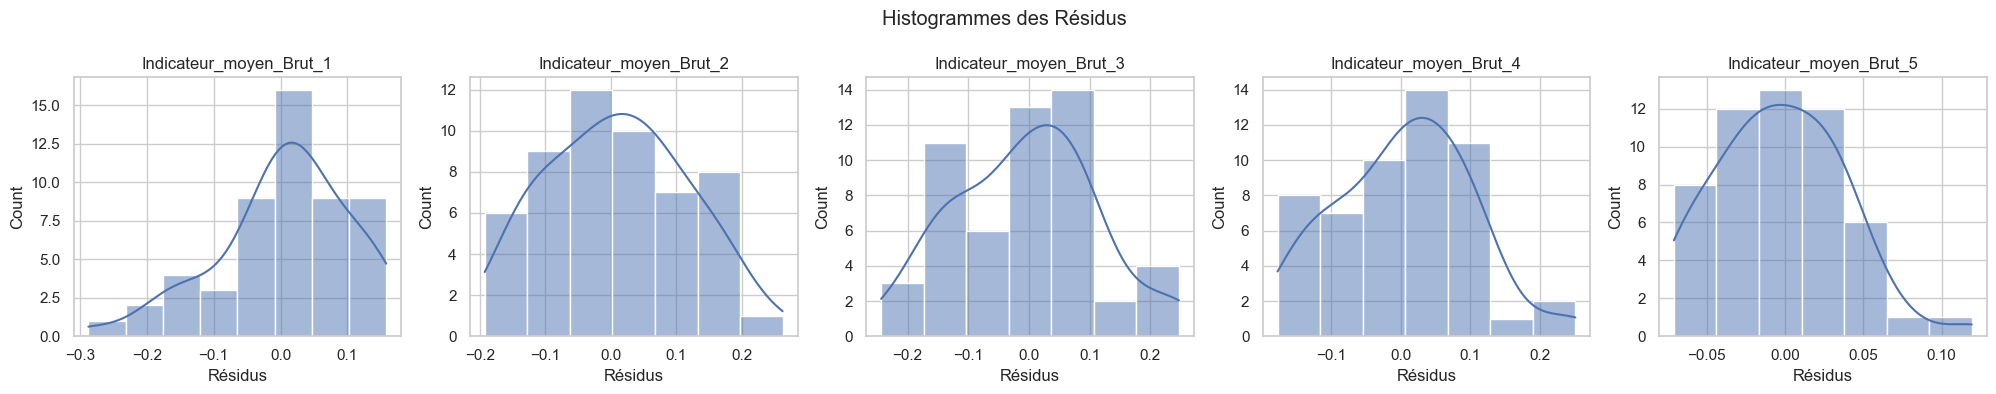

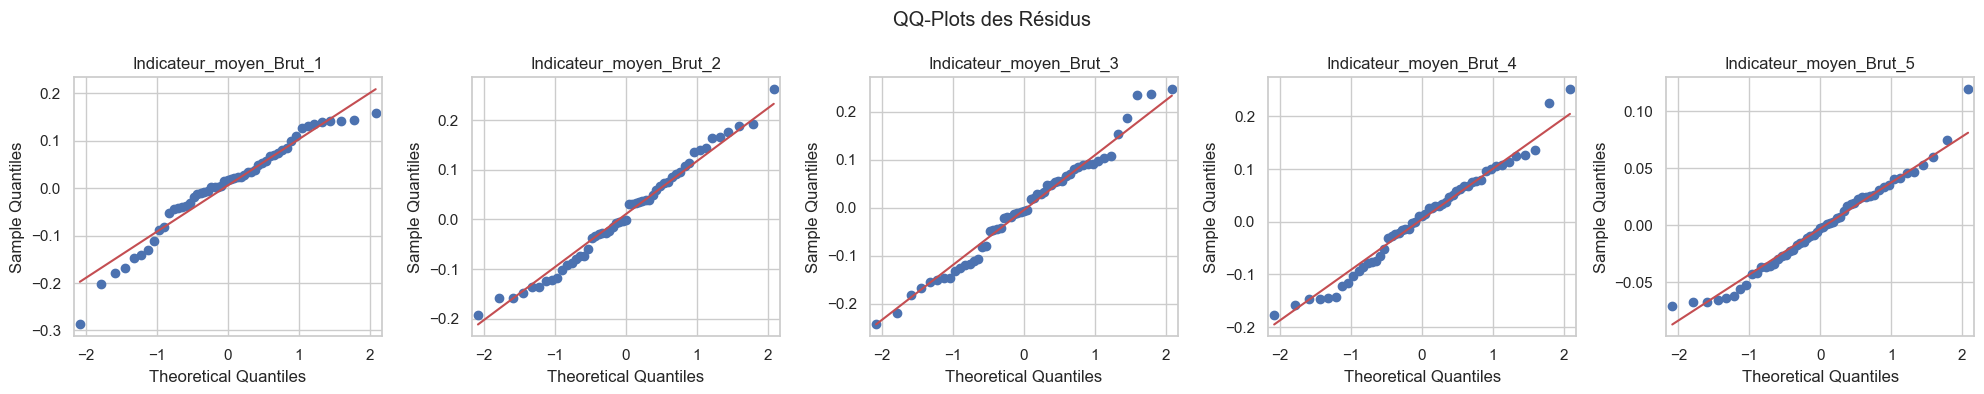

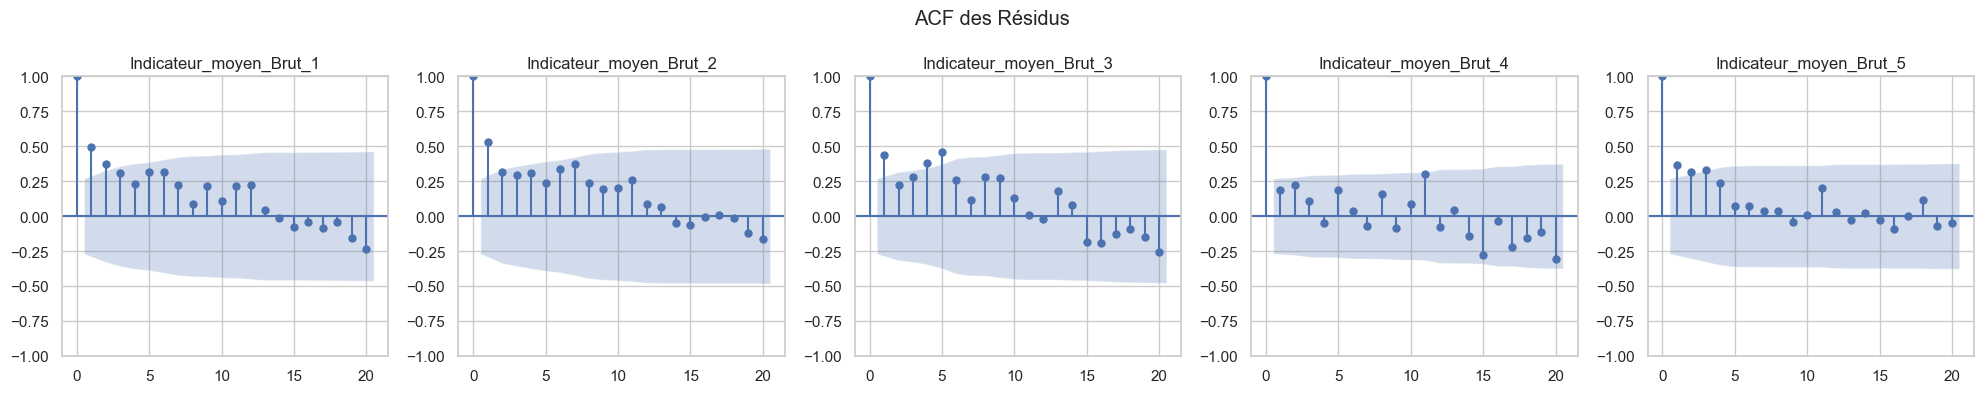

In [56]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, jarque_bera
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import zscore

# === Paramètres initiaux ===
segments = [f'Indicateur_moyen_Brut_{i}' for i in range(1, 6)]

# Étape 6 – Création des nouvelles variables macro
df["PIB_lag2"] = df["PIB_lag1"].shift(1)
df["TCH_ma3"] = df["TCH_diff1"].rolling(window=3).mean()
df["Inflation_ma3"] = df["Inflation_diff1"].rolling(window=3).mean()

# Étape 3 – Ajout d’une interaction pertinente
df["PIB_x_TCH"] = df["PIB"] * df["TCH_diff1"]

# Étape 7 – Nettoyage des outliers sur les cibles
z_scores = df[segments].apply(zscore)
df = df[(z_scores.abs() < 3).all(axis=1)].copy()

# Liste finale des variables explicatives
macro_vars = [
    'PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1',
    'PIB_lag1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1',
    'PIB_lag2', 'TCH_ma3', 'Inflation_ma3', 'PIB_x_TCH'
]

# Nettoyage final
df = df.dropna(subset=macro_vars + segments).copy()

# Dictionnaires pour stocker les sorties
residuals_dict = {}
fitted_dict = {}
stepwise_models = {}
stepwise_results = []

def backward_stepwise_mco(df, target, features, weight_col=None, vif_thresh=5.0, verbose=True):
    current_features = features.copy()
    while len(current_features) > 0:
        X = sm.add_constant(df[current_features])
        y = df[target]

        if weight_col:
            weights = df[weight_col]
            model = sm.WLS(y, X, weights=weights).fit()
        else:
            model = sm.OLS(y, X).fit()

        pvalues = model.pvalues.drop("const")
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif_max = vif_data[vif_data["Variable"] != "const"]["VIF"].max()

        if verbose:
            print(f"Features: {current_features} | AIC: {model.aic:.2f} | R²: {model.rsquared:.3f} | Max p: {pvalues.max():.3f} | Max VIF: {vif_max:.2f}")

        if pvalues.max() > 0.05:
            var_to_remove = pvalues.idxmax()
        elif vif_max > vif_thresh:
            var_to_remove = vif_data.sort_values("VIF", ascending=False)["Variable"].values[1]
        else:
            break

        current_features.remove(var_to_remove)

    return {
        "model": model,
        "features": current_features,
        "summary": model.summary()
    }

# === Modélisation par segment ===
for segment in segments:
    seg_num = segment.split('_')[-1]
    weight_col = f"PourcNoteCohorte5_{seg_num}"
    df_seg_model = df.dropna(subset=macro_vars + [segment, weight_col])
    result = backward_stepwise_mco(df_seg_model, segment, macro_vars, weight_col=weight_col)

    stepwise_models[segment] = result["model"]
    fitted_dict[segment] = result["model"].fittedvalues
    residuals_dict[segment] = result["model"].resid

    stepwise_results.append({
        "Segment": segment,
        "R²": round(result["model"].rsquared, 4),
        "AIC": round(result["model"].aic, 2),
        "Variables sélectionnées": result["features"]
    })

# Résumé final
stepwise_summary_df = pd.DataFrame(stepwise_results)
display(stepwise_summary_df)

# === Résidus vs Valeurs prédites ===
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, seg in enumerate(segments):
    axs[i].scatter(fitted_dict[seg], residuals_dict[seg], alpha=0.7)
    axs[i].axhline(0, color='red', linestyle='--')
    axs[i].set_title(seg)
    axs[i].set_xlabel("Prédictions")
    axs[i].set_ylabel("Résidus")
fig.suptitle("Résidus vs Valeurs Prédites")
plt.tight_layout()
plt.show()

# === Histogrammes des Résidus ===
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, seg in enumerate(segments):
    sns.histplot(residuals_dict[seg], kde=True, ax=axs[i])
    axs[i].set_title(seg)
    axs[i].set_xlabel("Résidus")
fig.suptitle("Histogrammes des Résidus")
plt.tight_layout()
plt.show()

# === QQ-Plots ===
fig = plt.figure(figsize=(20, 4))
for i, seg in enumerate(segments):
    ax = fig.add_subplot(1, 5, i+1)
    sm.qqplot(residuals_dict[seg], line='s', ax=ax)
    ax.set_title(seg)
fig.suptitle("QQ-Plots des Résidus")
plt.tight_layout()
plt.show()

# === ACF Résidus ===
fig = plt.figure(figsize=(20, 4))
for i, seg in enumerate(segments):
    ax = fig.add_subplot(1, 5, i+1)
    max_lags = min(20, len(residuals_dict[seg]) - 1)
    sm.graphics.tsa.plot_acf(residuals_dict[seg], lags=max_lags, ax=ax)
    ax.set_title(seg)
fig.suptitle("ACF des Résidus")
plt.tight_layout()
plt.show()


### Modélisation : 

In [65]:
print(df)

            Indicateur_moyen_Brut_1  Indicateur_moyen_Brut_2  \
date                                                           
2013-07-01                 0.412751                 0.658311   
2013-10-01                 0.337652                 0.690172   
2014-01-01                 0.413210                 0.556727   
2014-04-01                 0.350510                 0.613921   
2014-07-01                 0.330222                 0.616237   
2014-10-01                 0.328055                 0.547436   
2015-01-01                 0.293536                 0.669565   
2015-04-01                 0.418884                 0.601183   
2015-07-01                 0.362078                 0.515249   
2015-10-01                 0.429557                 0.558372   
2016-01-01                 0.360562                 0.584830   
2016-04-01                 0.252554                 0.394924   
2017-01-01                 0.272974                 0.492104   
2017-04-01                 0.316833     

In [67]:
# === Encodage en dummies sans colinéarité (drop_first) ===
quarter_dummies = pd.get_dummies(df["quarter"], prefix="Q", drop_first=True)

# === Fusion des dummies dans le dataset
df = pd.concat([df.drop(columns=["quarter"]), quarter_dummies], axis=1)


Indicateur_moyen_Brut_1: Features: ['PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1', 'PIB_lag1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1', 'PIB_lag2', 'TCH_ma3', 'Inflation_ma3', 'PIB_x_TCH'] | AIC: -63.93 | R²: 0.564 | Max p: 0.970 | Max VIF: 20.12
Indicateur_moyen_Brut_1: Features: ['PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1', 'PIB_lag1', 'IPL_lag1', 'TCH_lag1', 'PIB_lag2', 'TCH_ma3', 'Inflation_ma3', 'PIB_x_TCH'] | AIC: -65.93 | R²: 0.564 | Max p: 0.920 | Max VIF: 19.62
Indicateur_moyen_Brut_1: Features: ['PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1', 'PIB_lag1', 'IPL_lag1', 'PIB_lag2', 'TCH_ma3', 'Inflation_ma3', 'PIB_x_TCH'] | AIC: -67.91 | R²: 0.563 | Max p: 0.706 | Max VIF: 18.91
Indicateur_moyen_Brut_1: Features: ['PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1', 'PIB_lag1', 'IPL_lag1', 'TCH_ma3', 'Inflation_ma3', 'PIB_x_TCH'] | AIC: -69.69 | R²: 0.561 | Max p: 0.637 | Max VIF: 15.38
Indicateur_moyen_Brut_1: Features: ['PIB', 'IPL_diff1', 'Inflation_diff1', 'TC

Segment      R²     AIC  \
0  Indicateur_moyen_Brut_1  0.0782  -61.25   
1  Indicateur_moyen_Brut_2  0.4073  -89.89   
2  Indicateur_moyen_Brut_3  0.1270  -55.45   
3  Indicateur_moyen_Brut_4  0.0618  -54.12   
4  Indicateur_moyen_Brut_5  0.3849 -132.45   

                  Variables sélectionnées  
0                                      []  
1                               [TCH_ma3]  
2                              [IPL_lag1]  
3                                      []  
4  [PIB, IPL_diff1, TCH_diff1, PIB_x_TCH]

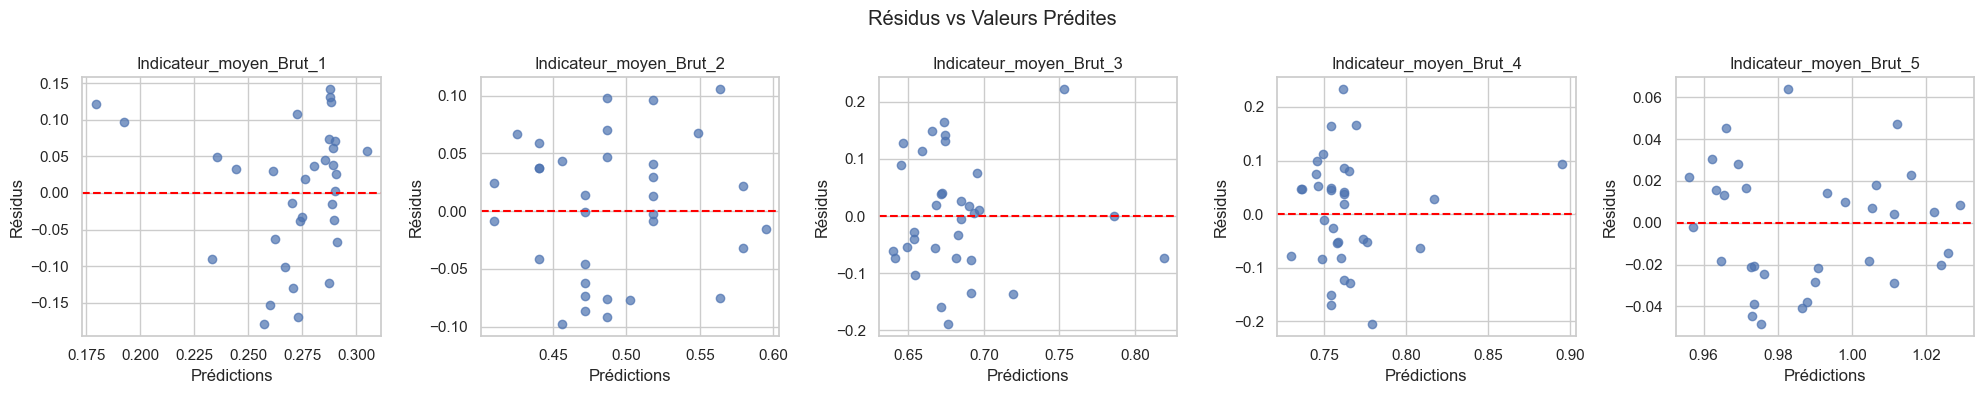

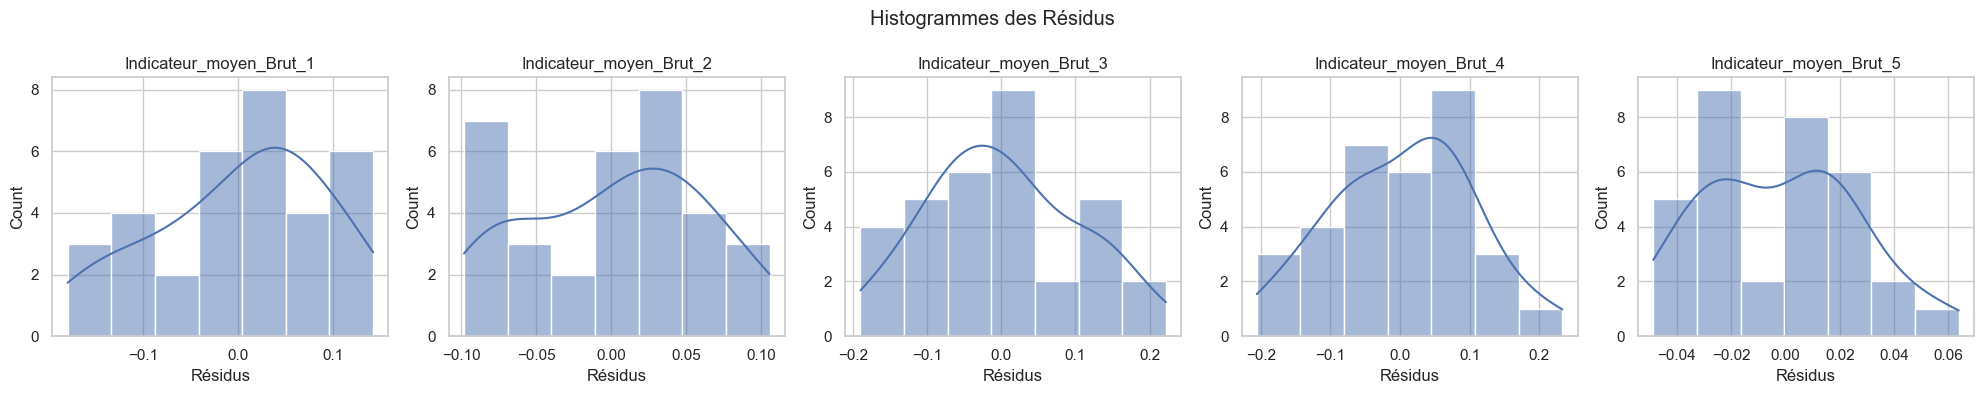

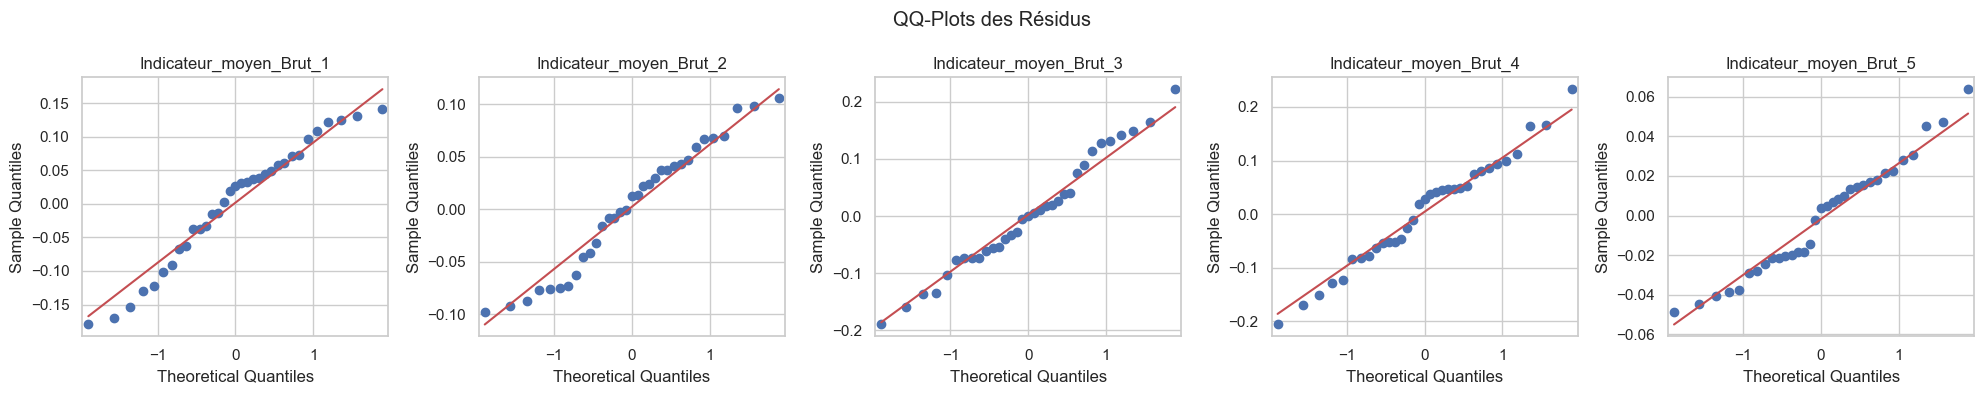

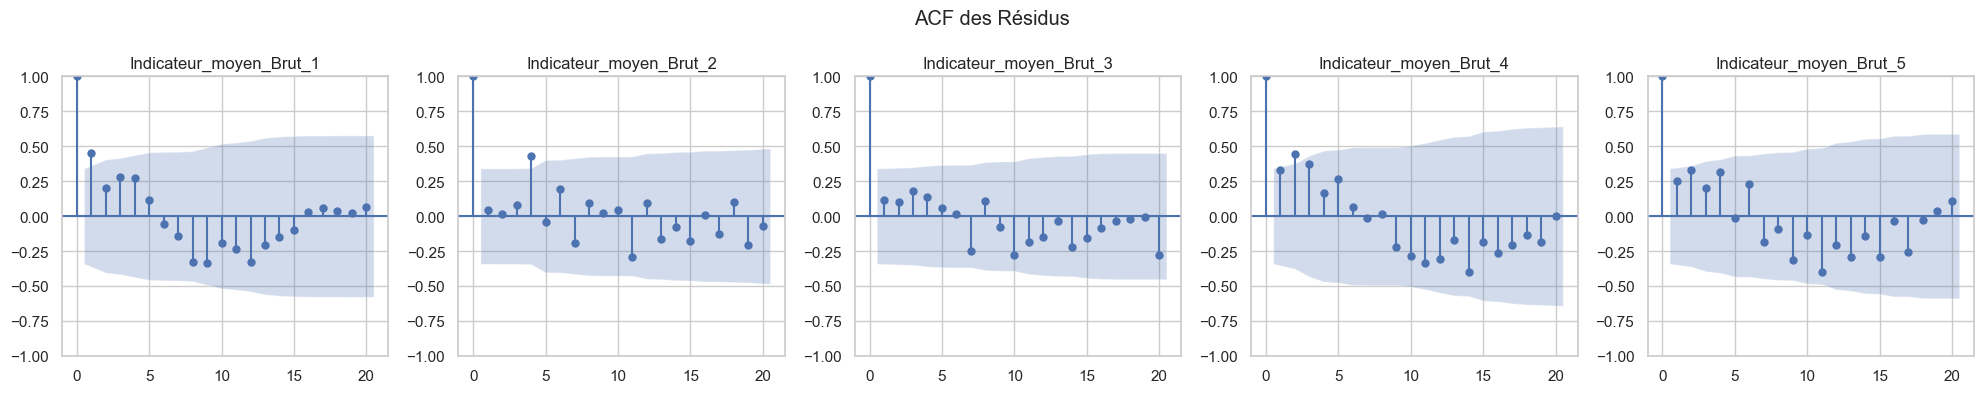

In [68]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import zscore

# === Paramètres initiaux ===
segments = [f'Indicateur_moyen_Brut_{i}' for i in range(1, 6)]

# === Features macro enrichies ===
df["PIB_lag2"] = df["PIB_lag1"].shift(1)
df["TCH_ma3"] = df["TCH_diff1"].rolling(window=3).mean()
df["Inflation_ma3"] = df["Inflation_diff1"].rolling(window=3).mean()
df["PIB_x_TCH"] = df["PIB"] * df["TCH_diff1"]

# === Nettoyage des outliers sur les cibles ===
z_scores = df[segments].apply(zscore)
df = df[(z_scores.abs() < 3).all(axis=1)].copy()

# Liste de toutes les variables explicatives potentielles
all_features = [
    'PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1',
    'PIB_lag1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1',
    'PIB_lag2', 'TCH_ma3', 'Inflation_ma3', 'PIB_x_TCH'
]

# Nettoyage final des NaNs
features_and_targets = all_features + segments
features_and_weights = features_and_targets + [f"PourcNoteCohorte5_{i}" for i in range(1, 6)]
df = df.dropna(subset=features_and_weights).copy()

# === Fonction de régression linéaire par segment avec backward stepwise ===
def backward_stepwise_mco(df, target, features, weight_col=None, vif_thresh=5.0, verbose=True):
    current_features = features.copy()
    while len(current_features) > 0:
        X = sm.add_constant(df[current_features])
        y = df[target]

        if weight_col:
            weights = df[weight_col]
            model = sm.WLS(y, X, weights=weights).fit()
        else:
            model = sm.OLS(y, X).fit()

        pvalues = model.pvalues.drop("const")
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif_max = vif_data[vif_data["Variable"] != "const"]["VIF"].max()

        if verbose:
            print(f"{target}: Features: {current_features} | AIC: {model.aic:.2f} | R²: {model.rsquared:.3f} | Max p: {pvalues.max():.3f} | Max VIF: {vif_max:.2f}")

        if pvalues.max() > 0.05:
            var_to_remove = pvalues.idxmax()
        elif vif_max > vif_thresh:
            var_to_remove = vif_data.sort_values("VIF", ascending=False)["Variable"].values[1]
        else:
            break

        current_features.remove(var_to_remove)

    return {
        "model": model,
        "features": current_features,
        "summary": model.summary()
    }

# === Modélisation séparée par segment ===
residuals_dict = {}
fitted_dict = {}
stepwise_models = {}
stepwise_results = []

for segment in segments:
    seg_num = segment.split('_')[-1]
    weight_col = f"PourcNoteCohorte5_{seg_num}"
    subset = macro_vars = all_features + [segment, weight_col]
    df_seg_model = df.dropna(subset=subset).copy()

    result = backward_stepwise_mco(df_seg_model, segment, all_features, weight_col=weight_col)

    stepwise_models[segment] = result["model"]
    fitted_dict[segment] = result["model"].fittedvalues
    residuals_dict[segment] = result["model"].resid

    stepwise_results.append({
        "Segment": segment,
        "R²": round(result["model"].rsquared, 4),
        "AIC": round(result["model"].aic, 2),
        "Variables sélectionnées": result["features"]
    })

# === Affichage récapitulatif ===
stepwise_summary_df = pd.DataFrame(stepwise_results)
display(stepwise_summary_df)

# === Visualisations ===
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, seg in enumerate(segments):
    axs[i].scatter(fitted_dict[seg], residuals_dict[seg], alpha=0.7)
    axs[i].axhline(0, color='red', linestyle='--')
    axs[i].set_title(seg)
    axs[i].set_xlabel("Prédictions")
    axs[i].set_ylabel("Résidus")
fig.suptitle("Résidus vs Valeurs Prédites")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, seg in enumerate(segments):
    sns.histplot(residuals_dict[seg], kde=True, ax=axs[i])
    axs[i].set_title(seg)
    axs[i].set_xlabel("Résidus")
fig.suptitle("Histogrammes des Résidus")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(20, 4))
for i, seg in enumerate(segments):
    ax = fig.add_subplot(1, 5, i+1)
    sm.qqplot(residuals_dict[seg], line='s', ax=ax)
    ax.set_title(seg)
fig.suptitle("QQ-Plots des Résidus")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(20, 4))
for i, seg in enumerate(segments):
    ax = fig.add_subplot(1, 5, i+1)
    max_lags = min(20, len(residuals_dict[seg]) - 1)
    sm.graphics.tsa.plot_acf(residuals_dict[seg], lags=max_lags, ax=ax)
    ax.set_title(seg)
fig.suptitle("ACF des Résidus")
plt.tight_layout()
plt.show()


c:\Users\dumas\PycharmProjects\Credit\Credit-Risk-Project\.envrisk\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\dumas\PycharmProjects\Credit\Credit-Risk-Project\.envrisk\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\dumas\PycharmProjects\Credit\Credit-Risk-Project\.envrisk\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\dumas\PycharmProjects\Credit\Credit-Risk-Project\.envrisk\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\dumas\PycharmProjects\Credit\Credit-Risk-Project\.envrisk\Lib\site-packages\statsmodels

Segment      R²   Méthode Variables sélectionnées
0  Indicateur_moyen_Brut_1  0.1634  baseline                      []
1  Indicateur_moyen_Brut_2  0.1632  baseline                      []
2  Indicateur_moyen_Brut_3  0.3212    custom                      []
3  Indicateur_moyen_Brut_4  0.4582  baseline                      []
4  Indicateur_moyen_Brut_5  0.5404    custom                      []

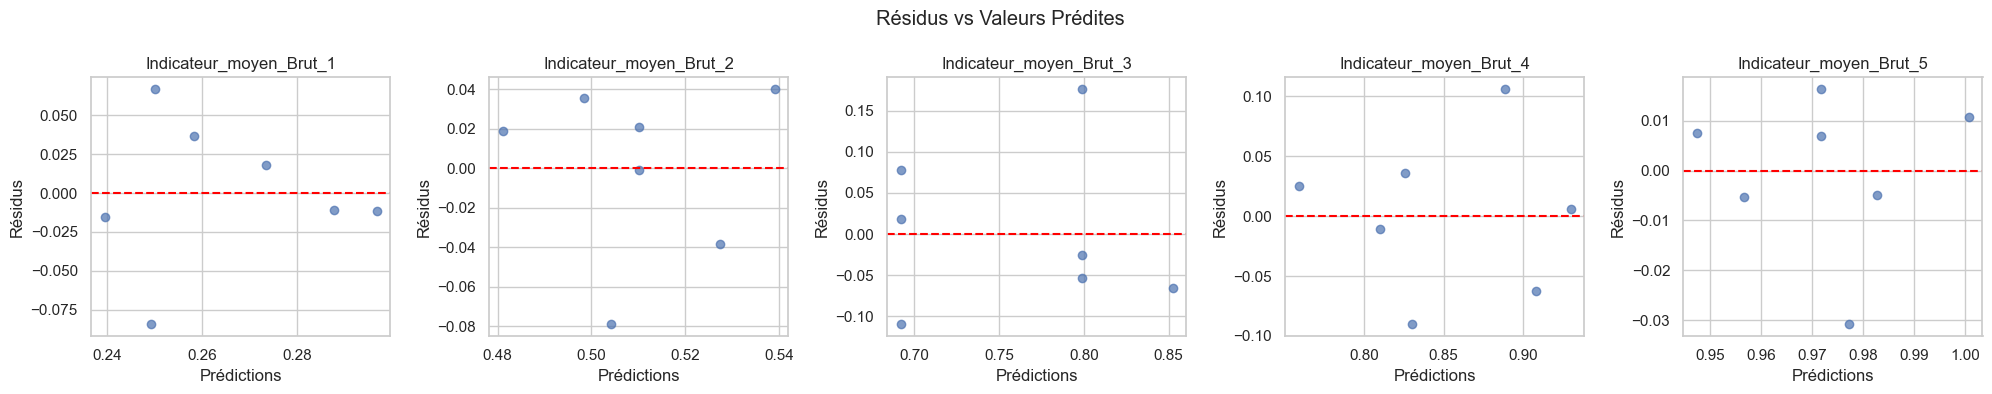

In [82]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import zscore

# === Paramètres initiaux ===
segments = [f'Indicateur_moyen_Brut_{i}' for i in range(1, 6)]

# === Features macro enrichies ===
df["PIB_lag2"] = df["PIB_lag1"].shift(1)
df["TCH_ma3"] = df["TCH_diff1"].rolling(window=3).mean()
df["Inflation_ma3"] = df["Inflation_diff1"].rolling(window=3).mean()
df["PIB_x_TCH"] = df["PIB"] * df["TCH_diff1"]

# === Transformations supplémentaires ===
df["PIB_log"] = np.log1p(df["PIB"])
df["TCH_diff1_sq"] = df["TCH_diff1"] ** 2
df["Inflation_diff1_sq"] = df["Inflation_diff1"] ** 2
df["TCH_ma3_log"] = np.log1p(df["TCH_ma3"])

# === Nettoyage des outliers sur les cibles ===
z_scores = df[segments].apply(zscore)
df = df[(pd.DataFrame(z_scores).abs() < 3).all(axis=1)].copy()

# === Variables explicatives ===
features_enriched = [
    'PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1',
    'PIB_lag1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1',
    'PIB_lag2', 'TCH_ma3', 'Inflation_ma3', 'PIB_x_TCH'
]

features_custom = [
    'PIB', 'PIB_log', 'IPL_diff1',
    'Inflation_diff1', 'Inflation_diff1_sq',
    'TCH_diff1', 'TCH_diff1_sq', 'PIB_lag1',
    'TCH_ma3', 'TCH_ma3_log', 'PIB_x_TCH'
]

# Nettoyage final des NaNs
features_and_targets = list(set(features_enriched + features_custom)) + segments
features_and_weights = features_and_targets + [f"PourcNoteCohorte5_{i}" for i in range(1, 6)]
df = df.dropna(subset=features_and_weights).copy()

# === Fonction de régression linéaire par segment avec backward stepwise ===
def backward_stepwise_mco(df, target, features, weight_col=None, vif_thresh=5.0):
    current_features = features.copy()
    while len(current_features) > 0:
        X = sm.add_constant(df[current_features])
        y = df[target]

        if weight_col:
            weights = df[weight_col]
            model = sm.WLS(y, X, weights=weights).fit()
        else:
            model = sm.OLS(y, X).fit()

        pvalues = model.pvalues.drop("const")
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif_max = vif_data[vif_data["Variable"] != "const"]["VIF"].max()

        if pvalues.max() > 0.05:
            var_to_remove = pvalues.idxmax()
        elif vif_max > vif_thresh:
            var_to_remove = vif_data.sort_values("VIF", ascending=False)["Variable"].values[1]
        else:
            break

        current_features.remove(var_to_remove)

    return {
        "model": model,
        "features": current_features,
        "summary": model.summary(),
        "r2": model.rsquared
    }

# === Comparaison baseline / custom pour segments 3 et 5 ===
def best_linear_model_for_segment(df, segment, weight_col, candidates):
    df_seg = df.dropna(subset=[segment, weight_col]).copy()
    results = []
    for label, features in candidates.items():
        res = backward_stepwise_mco(df_seg, segment, features, weight_col)
        res["label"] = label
        results.append(res)
    best = max(results, key=lambda r: r["r2"])
    return best

# === Modélisation ===
residuals_dict = {}
fitted_dict = {}
final_models = {}
stepwise_results = []

for segment in segments:
    seg_num = segment.split('_')[-1]
    weight_col = f"PourcNoteCohorte5_{seg_num}"

    if segment in ["Indicateur_moyen_Brut_3", "Indicateur_moyen_Brut_5"]:
        best_result = best_linear_model_for_segment(df, segment, weight_col, {
            "baseline": features_enriched,
            "custom": features_custom
        })
    else:
        best_result = backward_stepwise_mco(df, segment, features_enriched, weight_col)
        best_result["label"] = "baseline"

    final_models[segment] = best_result["model"]
    residuals_dict[segment] = best_result["model"].resid
    fitted_dict[segment] = best_result["model"].fittedvalues

    stepwise_results.append({
        "Segment": segment,
        "R²": round(best_result["r2"], 4),
        "Méthode": best_result["label"],
        "Variables sélectionnées": best_result["features"]
    })

# === Résumé final ===
stepwise_summary_df = pd.DataFrame(stepwise_results)
display(stepwise_summary_df)

# === Visualisations ===
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, seg in enumerate(segments):
    axs[i].scatter(fitted_dict[seg], residuals_dict[seg], alpha=0.7)
    axs[i].axhline(0, color='red', linestyle='--')
    axs[i].set_title(seg)
    axs[i].set_xlabel("Prédictions")
    axs[i].set_ylabel("Résidus")
fig.suptitle("Résidus vs Valeurs Prédites")
plt.tight_layout()
plt.show()

Indicateur_moyen_Brut_1 | R²: 0.320 | AIC: -75.46 | Max p: 0.996 | Max VIF: 32.83
Indicateur_moyen_Brut_1 | R²: 0.320 | AIC: -77.46 | Max p: 0.960 | Max VIF: 11.81
Indicateur_moyen_Brut_1 | R²: 0.319 | AIC: -79.46 | Max p: 0.899 | Max VIF: 11.66
Indicateur_moyen_Brut_1 | R²: 0.319 | AIC: -81.44 | Max p: 0.796 | Max VIF: 10.86
Indicateur_moyen_Brut_1 | R²: 0.318 | AIC: -83.35 | Max p: 0.456 | Max VIF: 10.27
Indicateur_moyen_Brut_1 | R²: 0.307 | AIC: -84.65 | Max p: 0.419 | Max VIF: 8.89
Indicateur_moyen_Brut_1 | R²: 0.295 | AIC: -85.85 | Max p: 0.386 | Max VIF: 8.36
Indicateur_moyen_Brut_1 | R²: 0.281 | AIC: -86.95 | Max p: 0.315 | Max VIF: 8.34
Indicateur_moyen_Brut_1 | R²: 0.263 | AIC: -87.78 | Max p: 0.236 | Max VIF: 8.33
Indicateur_moyen_Brut_1 | R²: 0.237 | AIC: -88.18 | Max p: 0.018 | Max VIF: 7.85
Indicateur_moyen_Brut_1 | R²: 0.068 | AIC: -80.98 | Max p: 0.941 | Max VIF: 1.05
Indicateur_moyen_Brut_1 | R²: 0.068 | AIC: -82.97 | Max p: 0.081 | Max VIF: 1.00
Indicateur_moyen_Brut_2

Segment      R²     AIC  Nb variables  \
0  Indicateur_moyen_Brut_1  0.0676  -82.97             0   
1  Indicateur_moyen_Brut_2  0.5740  -95.92             3   
2  Indicateur_moyen_Brut_3  0.2468  -77.33             2   
3  Indicateur_moyen_Brut_4  0.0947  -78.85             1   
4  Indicateur_moyen_Brut_5  0.2628 -155.87             4   

                         Variables sélectionnées  
0                                             []  
1             [PIB_lag1, TCH_ma3, Inflation_ma3]  
2                            [PIB_lag1, TCH_ma3]  
3                                      [TCH_ma3]  
4  [IPL_diff1, PIB_lag1, TCH_ma3, Inflation_ma3]

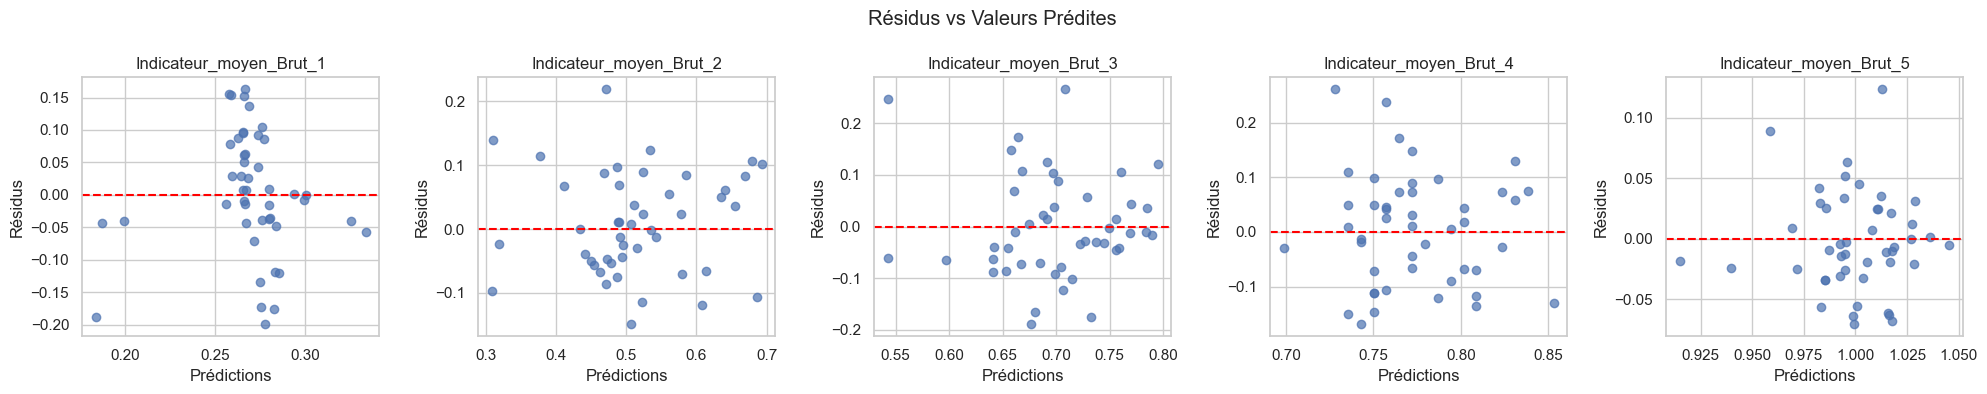

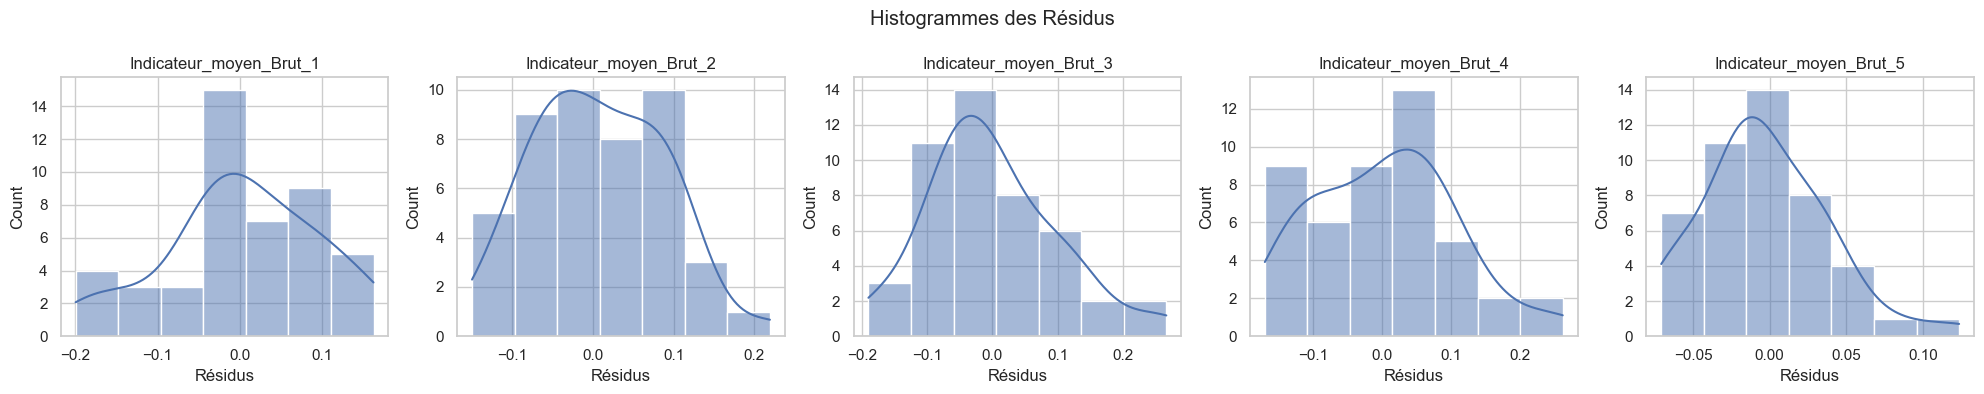

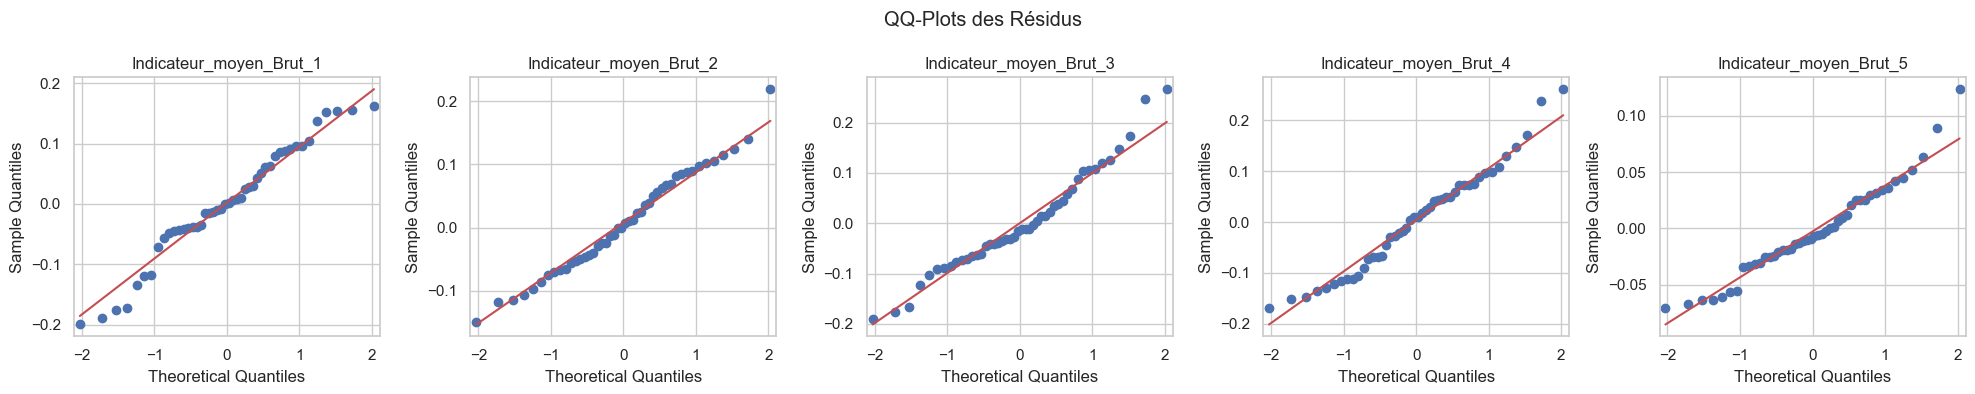

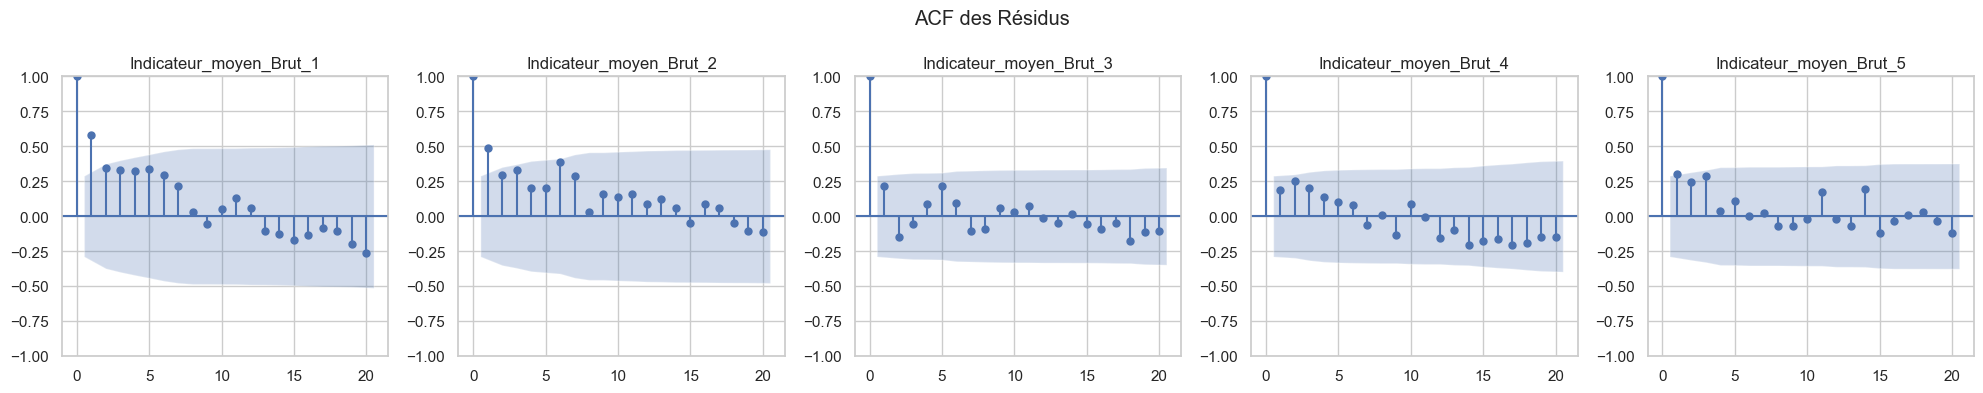

In [60]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import zscore

# === Paramètres initiaux ===
segments = [f'Indicateur_moyen_Brut_{i}' for i in range(1, 6)]

# === Création de nouvelles variables macro ===
df["PIB_lag2"] = df["PIB_lag1"].shift(1)
df["TCH_ma3"] = df["TCH_diff1"].rolling(window=3).mean()
df["Inflation_ma3"] = df["Inflation_diff1"].rolling(window=3).mean()
df["PIB_x_TCH"] = df["PIB"] * df["TCH_diff1"]

# === Suppression des outliers sur les cibles ===
df = df[(np.abs(zscore(df[segments])) < 3).all(axis=1)].copy()

# === Variables explicatives ===
variables_macro = [
    'PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1',
    'PIB_lag1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1',
    'PIB_lag2', 'TCH_ma3', 'Inflation_ma3', 'PIB_x_TCH'
]

# === Nettoyage des NaNs sur toutes les colonnes utiles ===
df = df.dropna(subset=variables_macro + segments + [f"PourcNoteCohorte5_{i}" for i in range(1, 6)]).copy()

# === Fonction de modélisation par segment ===
def backward_stepwise_mco(df, target, features, weight_col=None, vif_thresh=5.0, verbose=True):
    current_features = features.copy()
    while len(current_features) > 0:
        X = sm.add_constant(df[current_features])
        y = df[target]

        weights = df[weight_col] if weight_col else None
        model = sm.WLS(y, X, weights=weights).fit() if weights is not None else sm.OLS(y, X).fit()

        pvalues = model.pvalues.drop("const")
        vif_data = pd.DataFrame({
            "Variable": X.columns,
            "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        })
        vif_max = vif_data[vif_data["Variable"] != "const"]["VIF"].max()

        if verbose:
            print(f"{target} | R²: {model.rsquared:.3f} | AIC: {model.aic:.2f} | Max p: {pvalues.max():.3f} | Max VIF: {vif_max:.2f}")

        if pvalues.max() > 0.05:
            var_to_remove = pvalues.idxmax()
        elif vif_max > vif_thresh:
            var_to_remove = vif_data.sort_values("VIF", ascending=False)["Variable"].values[1]
        else:
            break

        current_features.remove(var_to_remove)

    return {
        "model": model,
        "features": current_features,
        "summary": model.summary()
    }

# === Application par segment ===
results = []
residuals_dict = {}
fitted_dict = {}
stepwise_models = {}

for segment in segments:
    seg_num = segment.split('_')[-1]
    weight_col = f"PourcNoteCohorte5_{seg_num}"

    df_seg = df.dropna(subset=variables_macro + [segment, weight_col])
    result = backward_stepwise_mco(df_seg, segment, variables_macro, weight_col=weight_col)

    model = result["model"]
    stepwise_models[segment] = model
    residuals_dict[segment] = model.resid
    fitted_dict[segment] = model.fittedvalues

    results.append({
        "Segment": segment,
        "R²": round(model.rsquared, 4),
        "AIC": round(model.aic, 2),
        "Nb variables": len(result["features"]),
        "Variables sélectionnées": result["features"]
    })

# === Affichage clair des métriques par segment ===
summary_df = pd.DataFrame(results)
print("📊 Résumé des performances par segment :")
display(summary_df)

# === Visualisation : Résidus vs Prédictions ===
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, seg in enumerate(segments):
    axs[i].scatter(fitted_dict[seg], residuals_dict[seg], alpha=0.7)
    axs[i].axhline(0, color='red', linestyle='--')
    axs[i].set_title(seg)
    axs[i].set_xlabel("Prédictions")
    axs[i].set_ylabel("Résidus")
fig.suptitle("Résidus vs Valeurs Prédites")
plt.tight_layout()
plt.show()

# === Visualisation : Histogrammes des Résidus ===
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, seg in enumerate(segments):
    sns.histplot(residuals_dict[seg], kde=True, ax=axs[i])
    axs[i].set_title(seg)
    axs[i].set_xlabel("Résidus")
fig.suptitle("Histogrammes des Résidus")
plt.tight_layout()
plt.show()

# === Visualisation : QQ-Plots ===
fig = plt.figure(figsize=(20, 4))
for i, seg in enumerate(segments):
    ax = fig.add_subplot(1, 5, i + 1)
    sm.qqplot(residuals_dict[seg], line='s', ax=ax)
    ax.set_title(seg)
fig.suptitle("QQ-Plots des Résidus")
plt.tight_layout()
plt.show()

# === Visualisation : ACF des Résidus ===
fig = plt.figure(figsize=(20, 4))
for i, seg in enumerate(segments):
    ax = fig.add_subplot(1, 5, i + 1)
    max_lags = min(20, len(residuals_dict[seg]) - 1)
    sm.graphics.tsa.plot_acf(residuals_dict[seg], lags=max_lags, ax=ax)
    ax.set_title(seg)
fig.suptitle("ACF des Résidus")
plt.tight_layout()
plt.show()


In [42]:
df.head()

Indicateur_moyen_Brut_1  Indicateur_moyen_Brut_2  \
date                                                           
2009-01-01                 0.451963                 0.918515   
2009-04-01                 0.598795                 0.693970   
2009-07-01                 0.460212                 0.676645   
2009-10-01                 0.431518                 0.697949   
2010-01-01                 0.302710                 0.681718   

            Indicateur_moyen_Brut_3  Indicateur_moyen_Brut_4  \
date                                                           
2009-01-01                 0.919843                 1.275864   
2009-04-01                 0.840965                 0.967390   
2009-07-01                 0.868909                 1.052081   
2009-10-01                 0.974173                 0.936315   
2010-01-01                 0.849149                 1.168515   

            Indicateur_moyen_Brut_5  PourcNoteCohorte5_1  PourcNoteCohorte5_2  \
date                                                                            
2009-01-01                 1.093203             0.115244             0.237795   
2009-04-01                 1.109015             0.109356             0.254647   
2009-07-01                 1.083922             0.100492             0.295740   
2009-10-01                 1.053459             0.102461             0.265383   
2010-01-01                 1.086222             0.109683             0.255927   

            PourcNoteCohorte5_3  PourcNoteCohorte5_4  PourcNoteCohorte5_5  \
date                                                                        
2009-01-01             0.130521             0.084689             0.431750   
2009-04-01             0.131660             0.101921             0.402416   
2009-07-01             0.142272             0.091207             0.370289   
2009-10-01             0.130819             0.098983             0.402354   
2010-01-01             0.143388             0.103970             0.387032   

            ...  TCH  Inflation  PIB_diff1  IPL_diff1  TCH_diff1  \
date        ...                                                    
2009-01-01  ...  8.3   0.301692  -1.430885  -2.593841        0.9   
2009-04-01  ...  8.8  -0.489570  -0.956314  -2.654313        0.5   
2009-07-01  ...  8.8  -0.362976  -0.769164  -1.824787        0.0   
2009-10-01  ...  9.2   0.914470   0.229433  -0.001851        0.4   
2010-01-01  ...  9.0   1.589859   1.265167   1.827158       -0.2   

            Inflation_diff1  PIB_lag1  IPL_lag1  Inflation_lag1  TCH_lag1  
date                                                                       
2009-01-01        -0.697982  0.144097 -2.204378       -1.979658       0.3  
2009-04-01        -0.791262 -1.286788 -2.593841       -0.697982       0.9  
2009-07-01         0.126594 -2.243102 -2.654313       -0.791262       0.5  
2009-10-01         1.277447 -3.012266 -1.824787        0.126594       0.0  
2010-01-01         0.675389 -2.782833 -0.001851        1.277447       0.4  

[5 rows x 23 columns]

In [43]:
df.index = pd.to_datetime(df.index)
df['year'] = df.index.year
df['quarter'] = df.index.quarter

macro_vars = [
    'PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1',
    'PIB_lag1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1'
]

segments = [
    'Indicateur_moyen_Brut_1',
    'Indicateur_moyen_Brut_2',
    'Indicateur_moyen_Brut_3',
    'Indicateur_moyen_Brut_4',
    'Indicateur_moyen_Brut_5'
]

# Supprimer les lignes incomplètes
df_model = df.dropna(subset=segments + macro_vars).copy()

import statsmodels.api as sm

models = {}

## Scénarios :

📅 Prévisions à 3 ans depuis T1 2024 – **Horizon T1 2025 / 2026 / 2027**

| Scénario | Année | PIB  | IPL | TCH  | Inflation |
| -------- | ----- | ---- | --- | ---- | --------- |
| REEL     | 2023  | 1.10 | -2  | 7.5  | 2.4       |
| PESS     | 2024  | -0.6 | -3  | 7.97 | 7.0       |
| CENT     | 2024  | 0.4  | 1   | 7.62 | 1.7       |
| OPTI     | 2024  | 1.5  | 3   | 7.2  | 0.0       |
| PESS     | 2025  | 0.25 | -5  | 8.24 | 5.0       |
| CENT     | 2025  | 0.95 | 2   | 7.7  | 1.78      |
| OPTI     | 2025  | 1.78 | 5   | 6.7  | 0.65      |
| PESS     | 2026  | 1.2  | -7  | 8.4  | 2.0       |
| CENT     | 2026  | 1.34 | 2   | 7.8  | 1.84      |
| OPTI     | 2026  | 1.6  | 7   | 7.0  | 2.1       |

---

 📅 Horizon T2 2025 / 2026 / 2027

| Scénario | Année | PIB    | IPL  | TCH    | Inflation |
| -------- | ----- | ------ | ---- | ------ | --------- |
| REEL     | 2023  | 1.10   | -2   | 7.5    | 2.4       |
| PESS     | 2024  | -0.387 | -3.5 | 8.0375 | 6.5       |
| CENT     | 2024  | 0.5375 | 1.25 | 7.64   | 1.72      |
| OPTI     | 2024  | 1.57   | 3.5  | 7.075  | 0.1625    |
| PESS     | 2025  | 0.4875 | -5.5 | 8.28   | 4.25      |
| CENT     | 2025  | 1.0475 | 2    | 7.725  | 1.795     |
| OPTI     | 2025  | 1.735  | 5.5  | 6.775  | 1.0125    |
| PESS     | 2026  | 1.225  | -6   | 8.3    | 1.975     |
| CENT     | 2026  | 1.355  | 1.75 | 7.725  | 1.88      |
| OPTI     | 2026  | 1.625  | 6    | 7.05   | 2.1       |

---

📅 Horizon T3 2025 / 2026 / 2027

| Scénario | Année | PIB    | IPL | TCH   | Inflation |
| -------- | ----- | ------ | --- | ----- | --------- |
| REEL     | 2023  | 1.10   | -2  | 7.5   | 2.4       |
| PESS     | 2024  | -0.175 | -4  | 8.105 | 6.0       |
| CENT     | 2024  | 0.675  | 1.5 | 7.66  | 1.74      |
| OPTI     | 2024  | 1.64   | 4   | 6.95  | 0.325     |
| PESS     | 2025  | 0.725  | -6  | 8.32  | 3.5       |
| CENT     | 2025  | 1.145  | 2   | 7.75  | 1.81      |
| OPTI     | 2025  | 1.69   | 6   | 6.85  | 1.375     |
| PESS     | 2026  | 1.25   | -5  | 8.2   | 1.95      |
| CENT     | 2026  | 1.37   | 1.5 | 7.65  | 1.92      |
| OPTI     | 2026  | 1.65   | 5   | 7.1   | 2.1       |

---

 📅 Horizon T4 2025 / 2026 / 2027

| Scénario | Année | PIB    | IPL  | TCH    | Inflation |
| -------- | ----- | ------ | ---- | ------ | --------- |
| REEL     | 2023  | 1.10   | -2   | 7.5    | 2.4       |
| PESS     | 2024  | 0.0375 | -4.5 | 8.1725 | 5.5       |
| CENT     | 2024  | 0.8125 | 1.75 | 7.68   | 1.76      |
| OPTI     | 2024  | 1.71   | 4.5  | 6.825  | 0.4875    |£
| PESS     | 2025  | 0.9625 | -6.5 | 8.36   | 2.75      |
| CENT     | 2025  | 1.2425 | 2    | 7.775  | 1.825     |
| OPTI     | 2025  | 1.645  | 6.5  | 6.925  | 1.7375    |
| PESS     | 2026  | 1.275  | -4   | 8.1    | 1.925     |
| CENT     | 2026  | 1.385  | 1.25 | 7.575  | 1.96      |
| OPTI     | 2026  | 1.675  | 4    | 7.15   | 2.1       |

## Prédictions

### ASKIP LES SCENARIOS EN INPUT DEVRAIT PERMETTRE DE PREDIRE POUR 2025 / 26/ 27, pas comprix

Verif PIB 2023 : 

In [44]:
# Filtrer les colonnes et les lignes pour l'année 2023
df_2023 = df.loc[df['year'] == 2023, ['PIB', 'IPL', 'TCH', 'Inflation']]

# Afficher le DataFrame filtré
print(df_2023)

                 PIB       IPL  TCH  Inflation
date                                          
2023-01-01  1.687226  5.190174  6.9   5.701873
2023-04-01  1.061365  3.664003  7.0   4.531319
2023-07-01  0.876149  1.650038  7.2   4.896221
2023-10-01  0.868858 -0.455149  7.3   3.705326


pas compatible avec le "last" ???

In [45]:
# Reconstruction des scénarios avec trimestres (T1 à T4) pour les années 2024 à 2026
scenarios_by_quarter = {
    "T1": {
        "PESS": {
            2024: {"PIB": -0.6, "IPL": -3, "TCH": 7.97, "Inflation": 7.0},
            2025: {"PIB": 0.25, "IPL": -5, "TCH": 8.24, "Inflation": 5.0},
            2026: {"PIB": 1.2, "IPL": -7, "TCH": 8.4, "Inflation": 2.0}
        },
        "CENT": {
            2024: {"PIB": 0.4, "IPL": 1, "TCH": 7.62, "Inflation": 1.7},
            2025: {"PIB": 0.95, "IPL": 2, "TCH": 7.7, "Inflation": 1.78},
            2026: {"PIB": 1.34, "IPL": 2, "TCH": 7.8, "Inflation": 1.84}
        },
        "OPTI": {
            2024: {"PIB": 1.5, "IPL": 3, "TCH": 7.2, "Inflation": 0.0},
            2025: {"PIB": 1.78, "IPL": 5, "TCH": 6.7, "Inflation": 0.65},
            2026: {"PIB": 1.6, "IPL": 7, "TCH": 7.0, "Inflation": 2.1}
        }
    },
    "T2": {
        "PESS": {
            2024: {"PIB": -0.387, "IPL": -3.5, "TCH": 8.0375, "Inflation": 6.5},
            2025: {"PIB": 0.4875, "IPL": -5.5, "TCH": 8.28, "Inflation": 4.25},
            2026: {"PIB": 1.225, "IPL": -6, "TCH": 8.3, "Inflation": 1.975}
        },
        "CENT": {
            2024: {"PIB": 0.5375, "IPL": 1.25, "TCH": 7.64, "Inflation": 1.72},
            2025: {"PIB": 1.0475, "IPL": 2, "TCH": 7.725, "Inflation": 1.795},
            2026: {"PIB": 1.355, "IPL": 1.75, "TCH": 7.725, "Inflation": 1.88}
        },
        "OPTI": {
            2024: {"PIB": 1.57, "IPL": 3.5, "TCH": 7.075, "Inflation": 0.1625},
            2025: {"PIB": 1.735, "IPL": 5.5, "TCH": 6.775, "Inflation": 1.0125},
            2026: {"PIB": 1.625, "IPL": 6, "TCH": 7.05, "Inflation": 2.1}
        }
    },
    "T3": {
        "PESS": {
            2024: {"PIB": -0.175, "IPL": -4, "TCH": 8.105, "Inflation": 6.0},
            2025: {"PIB": 0.725, "IPL": -6, "TCH": 8.32, "Inflation": 3.5},
            2026: {"PIB": 1.25, "IPL": -5, "TCH": 8.2, "Inflation": 1.95}
        },
        "CENT": {
            2024: {"PIB": 0.675, "IPL": 1.5, "TCH": 7.66, "Inflation": 1.74},
            2025: {"PIB": 1.145, "IPL": 2, "TCH": 7.75, "Inflation": 1.81},
            2026: {"PIB": 1.37, "IPL": 1.5, "TCH": 7.65, "Inflation": 1.92}
        },
        "OPTI": {
            2024: {"PIB": 1.64, "IPL": 4, "TCH": 6.95, "Inflation": 0.325},
            2025: {"PIB": 1.69, "IPL": 6, "TCH": 6.85, "Inflation": 1.375},
            2026: {"PIB": 1.65, "IPL": 5, "TCH": 7.1, "Inflation": 2.1}
        }
    },
    "T4": {
        "PESS": {
            2024: {"PIB": 0.0375, "IPL": -4.5, "TCH": 8.1725, "Inflation": 5.5},
            2025: {"PIB": 0.9625, "IPL": -6.5, "TCH": 8.36, "Inflation": 2.75},
            2026: {"PIB": 1.275, "IPL": -4, "TCH": 8.1, "Inflation": 1.925}
        },
        "CENT": {
            2024: {"PIB": 0.8125, "IPL": 1.75, "TCH": 7.68, "Inflation": 1.76},
            2025: {"PIB": 1.2425, "IPL": 2, "TCH": 7.775, "Inflation": 1.825},
            2026: {"PIB": 1.385, "IPL": 1.25, "TCH": 7.575, "Inflation": 1.96}
        },
        "OPTI": {
            2024: {"PIB": 1.71, "IPL": 4.5, "TCH": 6.825, "Inflation": 0.4875},
            2025: {"PIB": 1.645, "IPL": 6.5, "TCH": 6.925, "Inflation": 1.7375},
            2026: {"PIB": 1.675, "IPL": 4, "TCH": 7.15, "Inflation": 2.1}
        }
    }
}

# Display only to confirm structure
scenarios_by_quarter.keys()

dict_keys(['T1', 'T2', 'T3', 'T4'])

In [46]:
# Dernières valeurs macro observées en 2023
last_real = {"PIB": 1.10, "IPL": -2, "TCH": 7.5, "Inflation": 2.4}

last_real = {"PIB": 0.868858, "IPL": -0.455149, "TCH": 7.3, "Inflation": 3.705326}      

# Lancer les projections
projection_rows = []

for _, row in results_df.iterrows():
    segment = row["Segment"]
    coefs = row["Coefficients"]
    
    for trimestre, scenarios in scenarios_by_quarter.items():
        for scenario, year_data in scenarios.items():
            prev = last_real.copy()
            for year, values in year_data.items():
                PIB_diff1 = values["PIB"] - prev["PIB"]
                IPL_diff1 = values["IPL"] - prev["IPL"]
                TCH_diff1 = values["TCH"] - prev["TCH"]
                Inflation_diff1 = values["Inflation"] - prev["Inflation"]

                PIB_lag1 = prev["PIB"]
                IPL_lag1 = prev["IPL"]
                TCH_lag1 = prev["TCH"]
                Inflation_lag1 = prev["Inflation"]

                # Prédiction à partir des coefficients
                y_pred = (
                    coefs.get("const", 0)
                    + coefs.get("PIB_diff1", 0) * PIB_diff1
                    + coefs.get("IPL_diff1", 0) * IPL_diff1
                    + coefs.get("TCH_diff1", 0) * TCH_diff1
                    + coefs.get("Inflation_diff1", 0) * Inflation_diff1
                    + coefs.get("PIB_lag1", 0) * PIB_lag1
                    + coefs.get("IPL_lag1", 0) * IPL_lag1
                    + coefs.get("TCH_lag1", 0) * TCH_lag1
                    + coefs.get("Inflation_lag1", 0) * Inflation_lag1
                )

                projection_rows.append({
                    "Segment": segment,
                    "Scénario": scenario,
                    "Année": year,
                    "Trimestre": trimestre,
                    "Prévision_CCF": round(y_pred, 4)
                })

                prev = values  # mise à jour pour l’année suivante

# DataFrame final des prévisions
projection_df = pd.DataFrame(projection_rows)

projection_df.head()

NameError: name 'results_df' is not defined

#### Version des projections pour le GRANDIENT BOOSTING : 

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

gb_models = {}

for target in segments:
    data = df.dropna(subset=macro_vars + [target])
    X = df[[
    "PIB_diff1", "IPL_diff1", "TCH_diff1", "Inflation_diff1",
    "PIB_lag1", "IPL_lag1", "TCH_lag1", "Inflation_lag1"
]]

    y = data[target]

    model = GradientBoostingRegressor().fit(X, y)
    gb_models[target] = model


# Dernières valeurs macro observées
last_real = {"PIB": 0.868858, "IPL": -0.455149, "TCH": 7.3, "Inflation": 3.705326}

projection_rows = []

for segment, model in gb_models.items():
    for trimestre, scenarios in scenarios_by_quarter.items():
        for scenario, year_data in scenarios.items():
            prev = last_real.copy()
            for year, values in year_data.items():
                # Créer X_macro avec les 8 variables nécessaires
                X_macro = pd.DataFrame([{
                    "PIB_diff1": values["PIB"] - prev["PIB"],
                    "IPL_diff1": values["IPL"] - prev["IPL"],
                    "TCH_diff1": values["TCH"] - prev["TCH"],
                    "Inflation_diff1": values["Inflation"] - prev["Inflation"],
                    "PIB_lag1": prev["PIB"],
                    "IPL_lag1": prev["IPL"],
                    "TCH_lag1": prev["TCH"],
                    "Inflation_lag1": prev["Inflation"],
                }])

                y_pred = model.predict(X_macro)[0]

                projection_rows.append({
                    "Segment": segment,
                    "Scénario": scenario,
                    "Année": year,
                    "Trimestre": trimestre,
                    "Prévision_CCF": round(y_pred, 4)
                })

                prev = values  # mise à jour des lags


projection_df = pd.DataFrame(projection_rows)

projection_df.head()

Segment Scénario  Année Trimestre  Prévision_CCF
0  Indicateur_moyen_Brut_1     PESS   2024        T1         0.3660
1  Indicateur_moyen_Brut_1     PESS   2025        T1         0.3861
2  Indicateur_moyen_Brut_1     PESS   2026        T1         0.3771
3  Indicateur_moyen_Brut_1     CENT   2024        T1         0.2760
4  Indicateur_moyen_Brut_1     CENT   2025        T1         0.3327

(suite)

In [48]:
# 1. Restructurer les données historiques
df_real_melted = df.reset_index().melt(id_vars="date", 
                                            var_name="Segment", 
                                            value_name="Valeur_réelle")
df_real_melted["Année"] = df_real_melted["date"].dt.year
df_real_melted["Trimestre"] = "T" + df_real_melted["date"].dt.quarter.astype(str)
df_real_melted["Période"] = df_real_melted["Année"].astype(str) + "-" + df_real_melted["Trimestre"]

df_real_melted.head()

date                  Segment  Valeur_réelle  Année Trimestre  Période
0 2009-01-01  Indicateur_moyen_Brut_1       0.451963   2009        T1  2009-T1
1 2009-04-01  Indicateur_moyen_Brut_1       0.598795   2009        T2  2009-T2
2 2009-07-01  Indicateur_moyen_Brut_1       0.460212   2009        T3  2009-T3
3 2009-10-01  Indicateur_moyen_Brut_1       0.431518   2009        T4  2009-T4
4 2010-01-01  Indicateur_moyen_Brut_1       0.302710   2010        T1  2010-T1

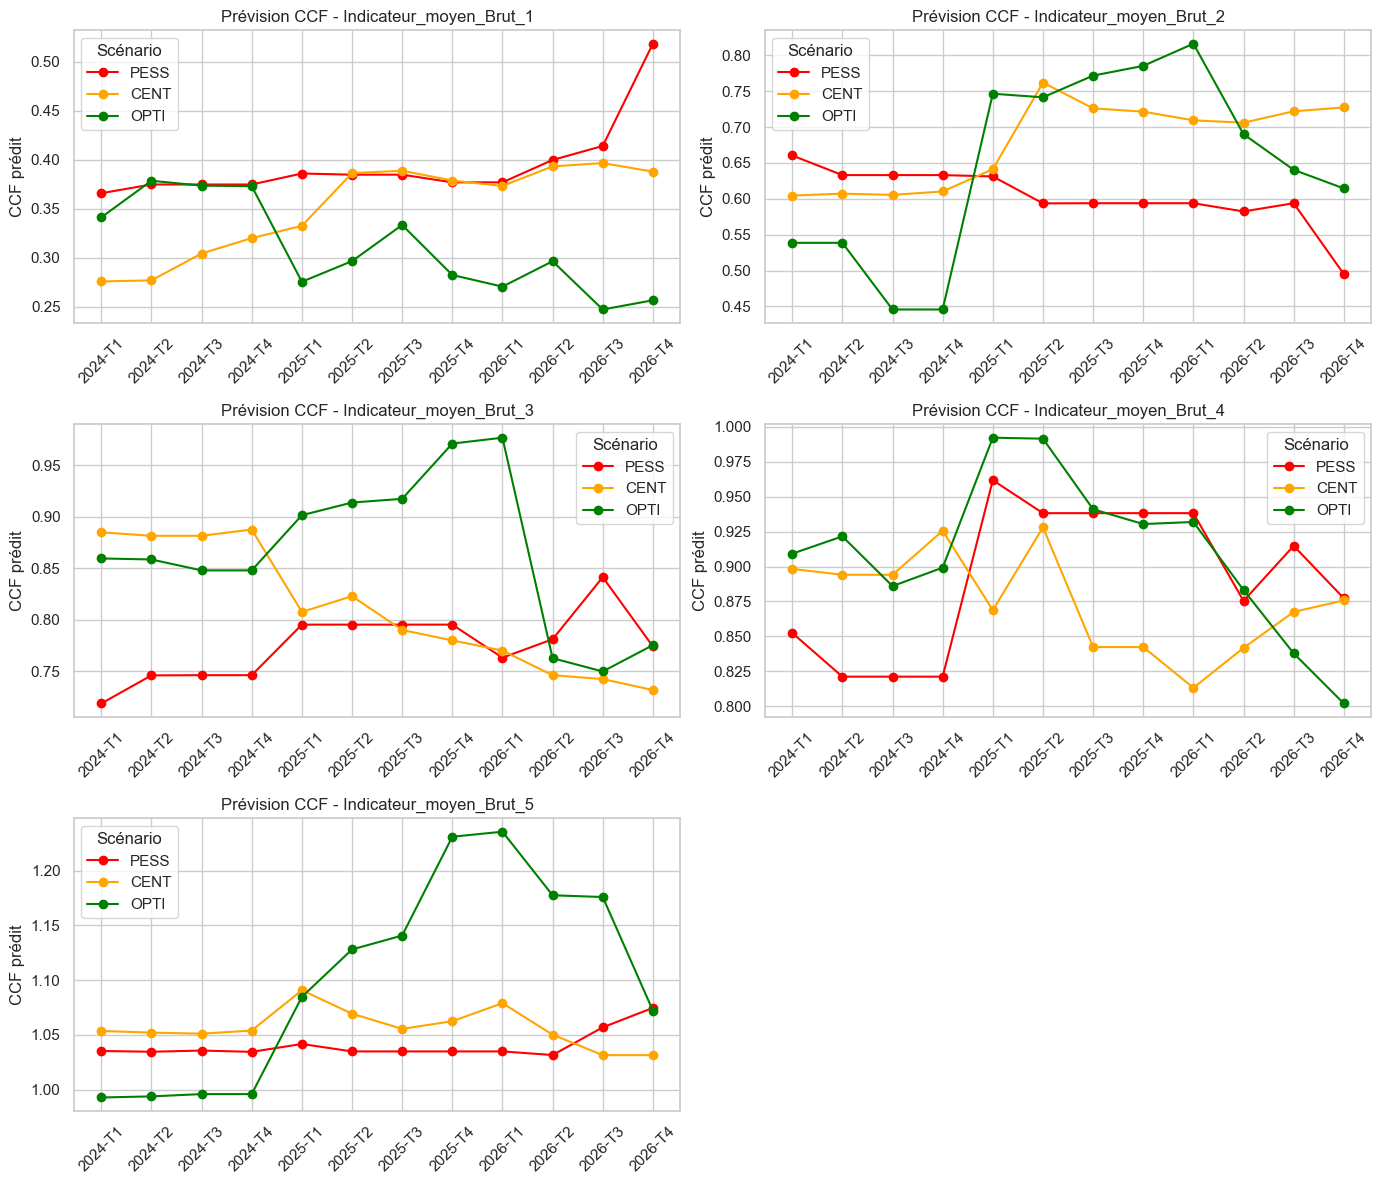

In [49]:
# Adapter les noms pour les trimestres : fusion Année + Trimestre
projection_df["Période"] = projection_df["Année"].astype(str) + "-" + projection_df["Trimestre"]

# Réordonner les périodes pour l'affichage
projection_df = projection_df.sort_values(by=["Segment", "Année", "Trimestre"])

# Génération des subplots 2 colonnes
segments = projection_df["Segment"].unique()
ncols = 2
nrows = (len(segments) + ncols - 1) // ncols
couleurs = {"PESS": "red", "CENT": "orange", "OPTI": "green"}

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows), sharex=False)
axes = axes.flatten()

for i, segment in enumerate(segments):
    ax = axes[i]
    df_seg = projection_df[projection_df["Segment"] == segment]
    
    for scenario in ["PESS", "CENT", "OPTI"]:
        df_scen = df_seg[df_seg["Scénario"] == scenario]
        ax.plot(df_scen["Période"], df_scen["Prévision_CCF"],
                marker='o', label=scenario, color=couleurs[scenario])
    
    ax.set_title(f"Prévision CCF - {segment}")
    ax.set_ylabel("CCF prédit")
    ax.set_xticks(df_seg["Période"].unique())
    ax.set_xticklabels(df_seg["Période"].unique(), rotation=45)
    ax.grid(True)
    ax.legend(title="Scénario")

# Supprimer les axes vides s’il y en a
for j in range(len(segments), len(axes)):
    fig.delaxes(axes[j])

axes[-1].set_xlabel("Période (Année-Trimestre)")
plt.tight_layout()
plt.show()

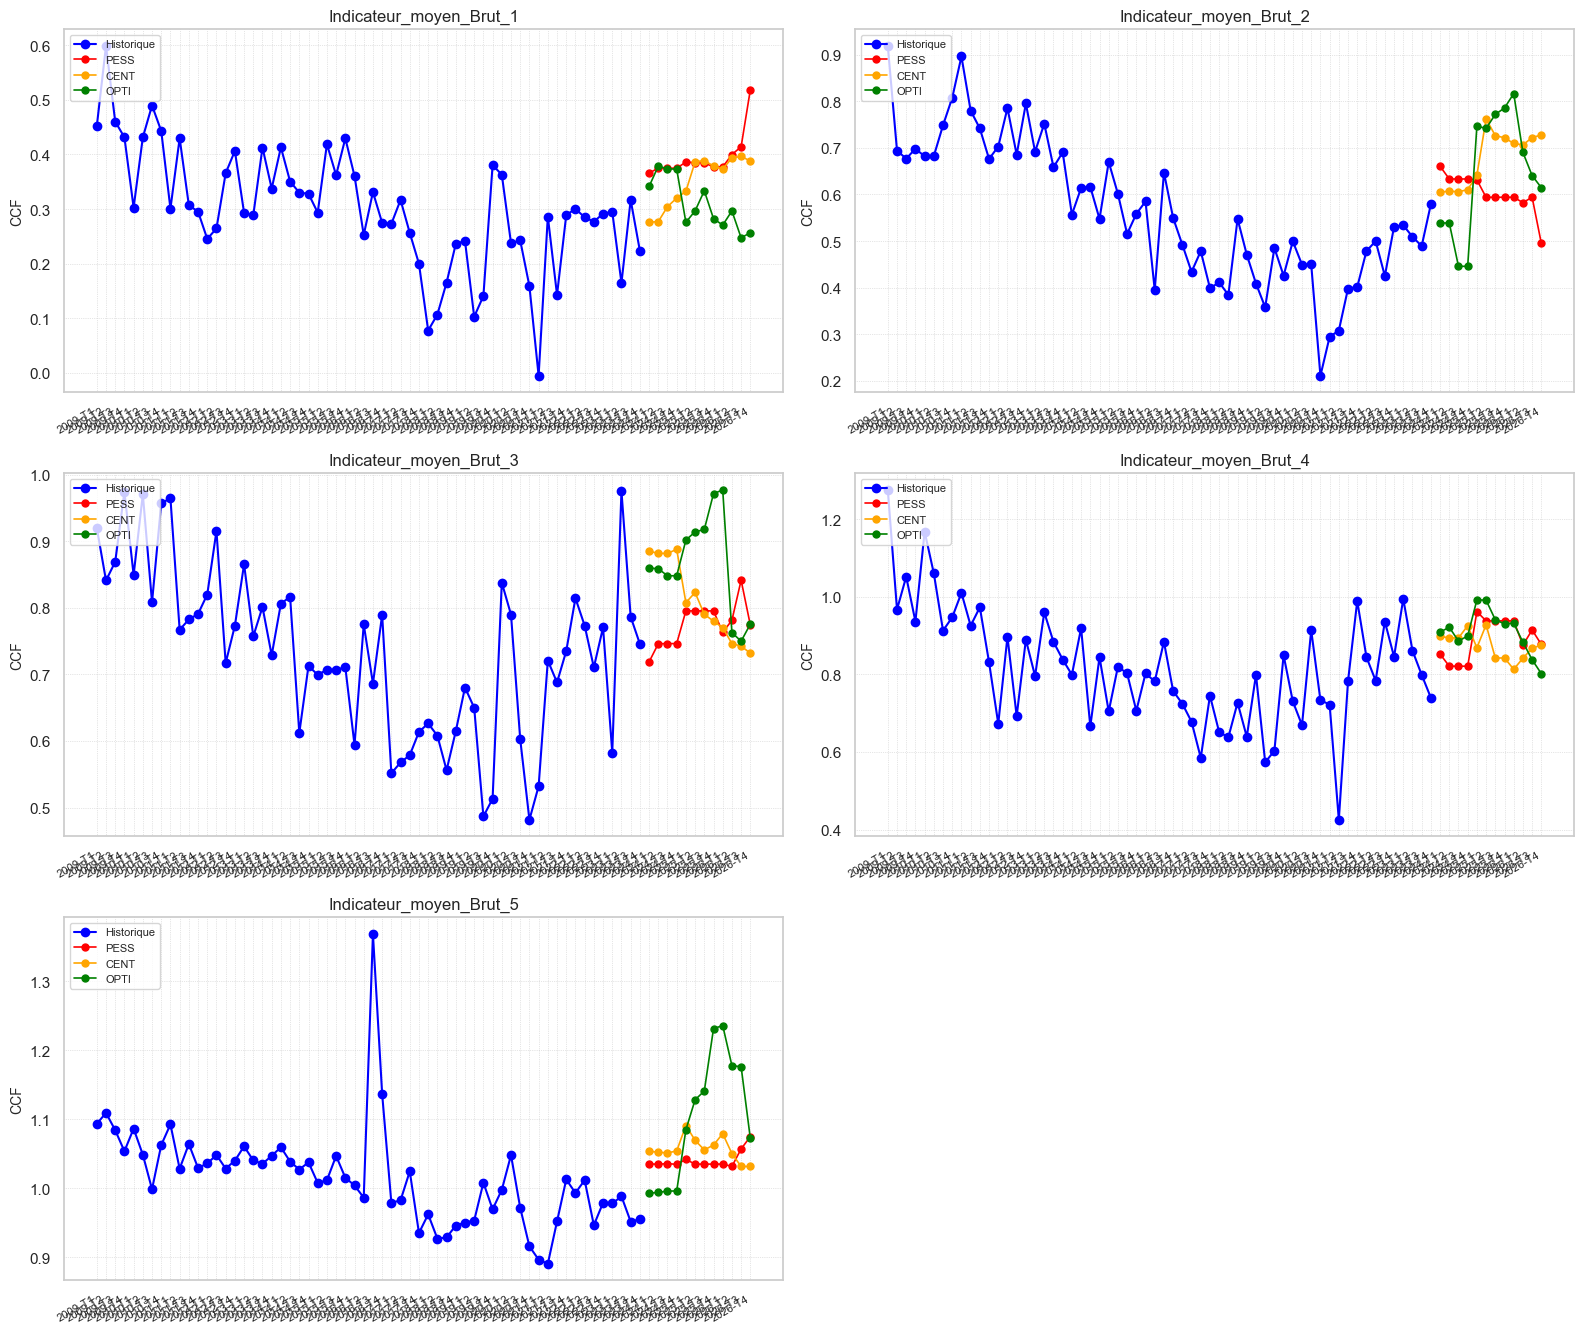

In [50]:
import matplotlib.pyplot as plt

# Générer Période fusionnée
projection_df["Période"] = projection_df["Année"].astype(str) + "-" + projection_df["Trimestre"]
df_real_melted["Période"] = df_real_melted["Année"].astype(str) + "-" + df_real_melted["Trimestre"]

# Ordre des périodes
ordre_periodes = sorted(set(projection_df["Période"]) | set(df_real_melted["Période"]))

# Plot propre
segments = projection_df["Segment"].unique()
ncols = 2
nrows = (len(segments) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4.5 * nrows), sharex=False)
axes = axes.flatten()

couleurs = {"PESS": "red", "CENT": "orange", "OPTI": "green"}

for i, segment in enumerate(segments):
    ax = axes[i]

    # Données réelles
    df_real = df_real_melted[df_real_melted["Segment"] == segment]
    ax.plot(df_real["Période"], df_real["Valeur_réelle"],
        linestyle='-', marker='o', color='blue', label="Historique")

    # Données prédites
    df_pred = projection_df[projection_df["Segment"] == segment]
    for scenario in couleurs:
        df_scen = df_pred[df_pred["Scénario"] == scenario]
        ax.plot(df_scen["Période"], df_scen["Prévision_CCF"],
                marker='o', markersize=5, linewidth=1.2,
                label=scenario, color=couleurs[scenario])
    
    
    ax.set_title(segment, fontsize=12)
    ax.set_ylabel("CCF", fontsize=10)
    ax.set_xticks(ordre_periodes)
    ax.set_xticklabels(ordre_periodes, rotation=30, ha='right', fontsize=8)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.legend(fontsize=8, loc="upper left")

# Supprimer axes vides si nb de segments impair
for j in range(len(segments), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Segment	Scénario	Année	Trimestre	Prévision_CCF
0	Indicateur_moyen_Brut_1	PESS	2024	T1	0.3651
1	Indicateur_moyen_Brut_1	PESS	2025	T1	0.3822
2	Indicateur_moyen_Brut_1	PESS	2026	T1	0.3736
3	Indicateur_moyen_Brut_1	CENT	2024	T1	0.2621
4	Indicateur_moyen_Brut_1	CENT	2025	T1	0.3296

In [ ]:
import matplotlib.pyplot as plt

# Fusion année-trimestre pour l'axe X
projection_df["Période"] = projection_df["Année"].astype(str) + "-" + projection_df["Trimestre"]
df_real_melted["Période"] = df_real_melted["Année"].astype(str) + "-" + df_real_melted["Trimestre"]

# Ordonner les périodes
ordre_periodes = sorted(set(projection_df["Période"]) | set(df_real_melted["Période"]))

# Couleurs
couleurs_scenarios = {"PESS": "red", "CENT": "orange", "OPTI": "green"}
couleurs_segments = plt.cm.tab10.colors  # Couleurs distinctes pour les historiques des segments

segments = projection_df["Segment"].unique()

plt.figure(figsize=(18, 8))

# Tracer l'historique pour chaque segment (en bleu ou différent si souhaité)
for i, segment in enumerate(segments):
    df_hist = df_real_melted[df_real_melted["Segment"] == segment]
    plt.plot(df_hist["Période"], df_hist["Valeur_réelle"],
             linestyle='--', marker='x', label=f"{segment} - Historique",
             color=couleurs_segments[i % len(couleurs_segments)])

# Tracer les prévisions pour chaque segment et chaque scénario
for i, segment in enumerate(segments):
    df_pred = projection_df[projection_df["Segment"] == segment]
    for scenario, color in couleurs_scenarios.items():
        df_scen = df_pred[df_pred["Scénario"] == scenario]
        plt.plot(df_scen["Période"], df_scen["Prévision_CCF"],
                 marker='x', linewidth=1.5, alpha=0.7,
                 label=f"{segment} - {scenario}", color=color)

# Mise en forme
plt.xticks(ordre_periodes, rotation=45, ha='right', fontsize=9)
plt.xlabel("Période")
plt.ylabel("CCF")
plt.title("CCF Historique + Prévisions - Tous Segments et Scénarios")
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.show()

In [ ]:
poids_scenarios = {
    "PESS": 0.25,
    "CENT": 0.50,
    "OPTI": 0.25
}

# choisir aléatoirement 

projection_df["Poids"] = projection_df["Scénario"].map(poids_scenarios)

# Prédiction pondérée par période et segment
df_final = (
    projection_df
    .assign(pondéré=projection_df["Prévision_CCF"] * projection_df["Poids"])
    .groupby(["Segment", "Année", "Trimestre", "Période"], as_index=False)
    .agg({"pondéré": "sum"})
    .rename(columns={"pondéré": "CCF_Forward_Looking"})
)

In [ ]:
import matplotlib.pyplot as plt

# Définir les poids de scénario
poids_scenarios = {"PESS": 0.25, "CENT": 0.50, "OPTI": 0.25}
projection_df["Poids"] = projection_df["Scénario"].map(poids_scenarios)

# Ajouter Période si elle a disparu
projection_df["Période"] = projection_df["Année"].astype(str) + "-" + projection_df["Trimestre"]

# Calcul du CCF Forward Looking pondéré
df_fl = (
    projection_df
    .assign(pondéré=projection_df["Prévision_CCF"] * projection_df["Poids"])
    .groupby(["Segment", "Année", "Trimestre", "Période"], as_index=False)
    .agg({"pondéré": "sum"})
    .rename(columns={"pondéré": "CCF_Forward_Looking"})
)

# Préparer les données historiques
df_real_melted["Période"] = df_real_melted["Année"].astype(str) + "-" + df_real_melted["Trimestre"]
ordre_periodes = sorted(set(projection_df["Période"]) | set(df_real_melted["Période"]))

# Plot
plt.figure(figsize=(18, 8))

# Tracer l'historique
for i, segment in enumerate(segments):
    df_hist = df_real_melted[df_real_melted["Segment"] == segment]
    plt.plot(df_hist["Période"], df_hist["Valeur_réelle"],
             linestyle='--', marker='x', label=f"{segment} - Historique",
             color=couleurs_segments[i % len(couleurs_segments)])


# Tracer les prévisions Forward Looking (moyennées)
for i, segment in enumerate(segments):
    df_seg_fl = df_fl[df_fl["Segment"] == segment]
    plt.plot(df_seg_fl["Période"], df_seg_fl["CCF_Forward_Looking"],
             linestyle='--', marker='x', label=f"{segment} - FL pondéré",
             color=couleurs_segments[i % len(couleurs_segments)])

# Finalisation
plt.xticks(ordre_periodes, rotation=45, ha='right', fontsize=9)
plt.xlabel("Période")
plt.ylabel("CCF")
plt.title("CCF Historique, Scénarios et Projection Forward-Looking")
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.tight_layout()
plt.show()

